# 数据质控与过滤

## 数据前期处理和矫正

### 导入数据

In [217]:
library(limma)
library(Seurat)
library(dplyr)
library(magrittr)

In [218]:
setwd("D:\\Data\\File\\单细胞测序\\scRNA-seq-Bioinformation_analyse\\3. Data QC & Filter")             #设置工作目录

In [219]:
#读取文件
rt=read.table("geneMatrix.txt",sep="\t",header=T,check.names=F)
rt=as.matrix(rt)

### 数据预处理

In [220]:
#对多行中出现的重复基因取均值
rownames(rt)=rt[,1]
exp=rt[,2:ncol(rt)]
dimnames=list(rownames(exp),colnames(exp))
data=matrix(as.numeric(as.matrix(exp)),nrow=nrow(exp),dimnames=dimnames)
data=avereps(data)

In [221]:
#将矩阵转换为Seurat对象，并对数据进行过滤
pbmc <- CreateSeuratObject(counts = data,project = "seurat", min.cells = 3, min.features = 50, names.delim = "_",)

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


- 去除掉存在样品数目小于3的基因
- 删除掉那些测到小于50个基因的细胞
- 设置样品名分隔符为"_"

In [222]:
pbmc

An object of class Seurat 
17952 features across 1353 samples within 1 assay 
Active assay: RNA (17952 features)

In [223]:
#使用PercentageFeatureSet函数计算线粒体基因的百分比
pbmc[["percent.mt"]] <- PercentageFeatureSet(object = pbmc, pattern = "^MT-")

In [224]:
pbmc

An object of class Seurat 
17952 features across 1353 samples within 1 assay 
Active assay: RNA (17952 features)

### 绘制小提琴图

测试绘图函数

Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
"All cells have the same value of percent.mt."


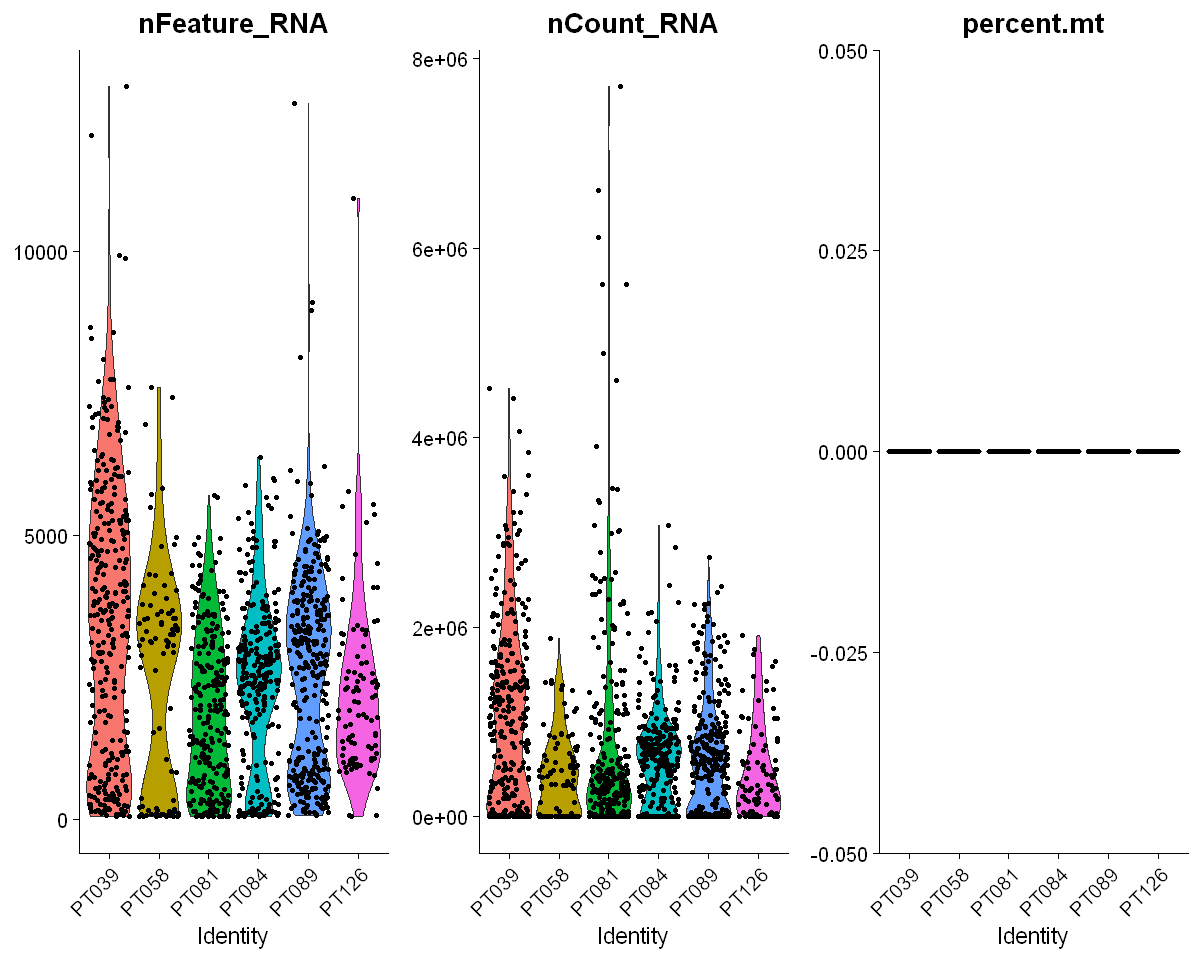

In [225]:
options(repr.plot.width=10, repr.plot.height=8)  #设置Jupyter Notebook中R绘制的图像大小
VlnPlot(object = pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

- 根据质控图像，具体设置删除点的阈值

In [226]:
pdf(file="3.featureViolin.pdf",width=10,height=6)           #保存基因特征小提琴图
VlnPlot(object = pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
dev.off()

Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
"All cells have the same value of percent.mt."


png 
  2

### 根据图像设置过滤的阈值
原则：
- 不能将太多的细胞/样品删除掉
- 删除掉线粒体基因百分率大于5%的样品

In [227]:
pbmc <- subset(x = pbmc, subset = nFeature_RNA > 50 & percent.mt < 5)    #对数据进行过滤

### 测序深度的相关性绘图

Warning message in cor(x = data[, 1], y = data[, 2]):
"标准差为零"


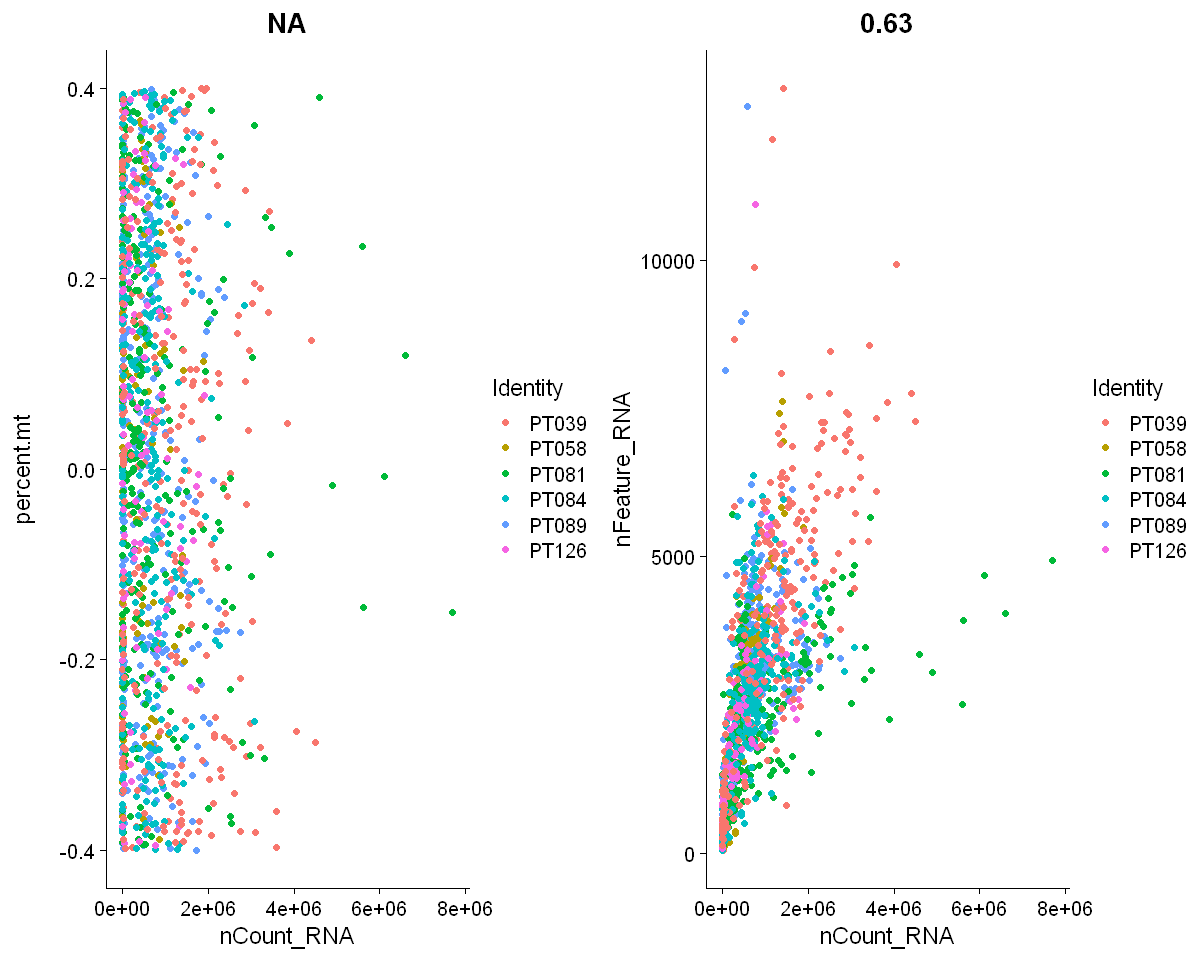

In [228]:
# 图像测试
options(repr.plot.width=10, repr.plot.height=8)  #设置Jupyter Notebook中R绘制的图像大小
plot1 <- FeatureScatter(object = pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt",pt.size=1.5)
plot2 <- FeatureScatter(object = pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA",,pt.size=1.5)
CombinePlots(plots = list(plot1, plot2))

In [229]:
pdf(file="3.featureCor.pdf",width=10,height=6)              #保存基因特征相关性图
plot1 <- FeatureScatter(object = pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt",pt.size=1.5)
plot2 <- FeatureScatter(object = pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA",,pt.size=1.5)
CombinePlots(plots = list(plot1, plot2))
dev.off()

Warning message in cor(x = data[, 1], y = data[, 2]):
"标准差为零"


png 
  2

### 数据标准化
- 由于对一些样品和数据删除之后，需要对counts进行标准化
- 此处标准化的方法为取log
- 将测序的深度，矫正为10000。即校正为，假设测了10万条reads后，每个基因测到的数目

In [230]:
#对数据进行标准化
pbmc <- NormalizeData(object = pbmc, normalization.method = "LogNormalize", scale.factor = 10000)

### 提取那些在细胞间变异系数较大的基因
- 提取前1500个基因

In [231]:
pbmc <- FindVariableFeatures(object = pbmc, selection.method = "vst", nfeatures = 1500)

#### 输出特征方差图

In [232]:
#提取出前10个波动最大的基因
top10 <- head(x = VariableFeatures(object = pbmc), 10)

In [233]:
top10
class(top10)

[1] "HP"      "KCNJ2"   "PLA2G2A" "INMT"    "PRG4"    "CCL3"    "SPP1"   
 [8] "LYZ"     "TAT"     "ELK2AP"

[1] "character"

When using repel, set xnudge and ynudge to 0 for optimal results



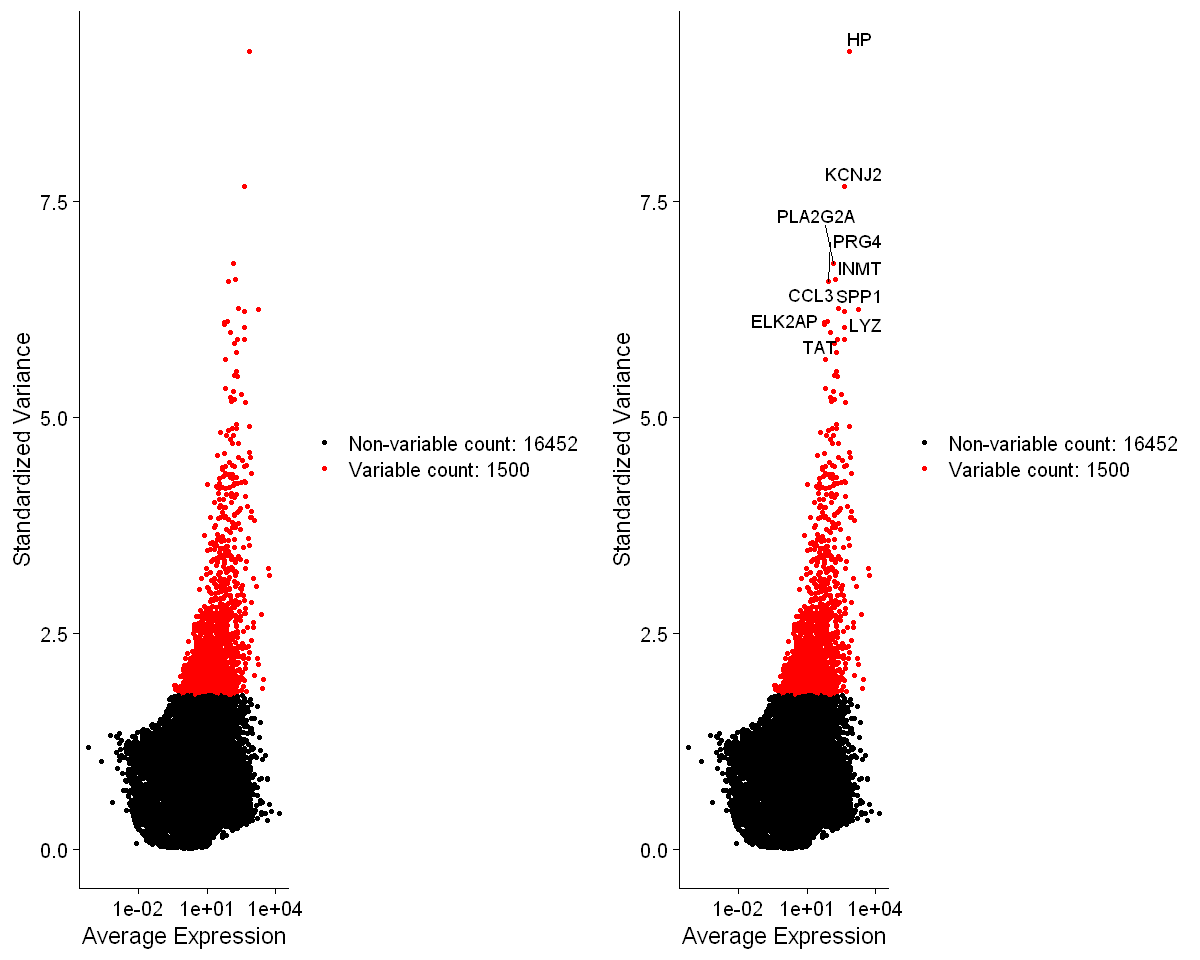

In [234]:
#测试绘图
options(repr.plot.width=10, repr.plot.height=8)  #设置Jupyter Notebook中R绘制的图像大小
plot1 <- VariableFeaturePlot(object = pbmc)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
CombinePlots(plots = list(plot1, plot2))

- 1000个基因表达的均值和标准差的散点图
- 选择表达量波动比较大的基因——选择标准差大的基因（红色的点）
- 一般筛选出1000~2000个基因，此处筛选出1500个基因，并标注差异最大的10个基因

In [235]:
pdf(file="3.featureVar.pdf",width=10,height=6)              #保存基因特征方差图
plot1 <- VariableFeaturePlot(object = pbmc)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
CombinePlots(plots = list(plot1, plot2))
dev.off()

When using repel, set xnudge and ynudge to 0 for optimal results



png 
  2

# PCA主成分分析

> PCA主成分分析：一种线性降维，速度比较快，所以用作条tSNE聚类前的处理

In [236]:
setwd("D:\\Data\\File\\单细胞测序\\scRNA-seq-Bioinformation_analyse\\4.PCA")             #设置工作目录

### 数据格式标准化

In [237]:
pbmc=ScaleData(pbmc)                     #PCA降维之前的标准预处理步骤

Centering and scaling data matrix



### 运行PCA分析脚本

- 选择前20维的基因进行分析
- 参数：pc.genes=VariableFeatures(object = pbmc) 选择波动最大前1500个的那些基因进行分析

In [238]:
pbmc=RunPCA(object= pbmc,npcs = 20,pc.genes=VariableFeatures(object = pbmc))     #PCA分析

PC_ 1 
Positive:  SOX4, TFAP2C, ITGB8, PARD6B, SOX11, TRPS1, CXADR, RND3, BRIX1, NOP58 
	   SPARC, TBL1XR1, C1S, TLK1, TOB1, HMGCS1, C1R, ETNK1, LTF, PTBP2 
	   FSTL1, ELF5, PPP3CA, ANP32E, PCMTD1, PPP1R9A, CTGF, TRA2A, RDH10, BAG4 
Negative:  FCGR3A, FCGR2A, CSF1R, HLA-DRB1, HLA-DMB, CD163, IFI30, HLA-DRB5, HLA-DRA, FCER1G 
	   C1QC, LAPTM5, VSIG4, CYBB, HLA-DPB1, MSR1, CD14, CD68, HLA-DPA1, HLA-DQB1 
	   C1QB, FCGR2B, HLA-DQA1, SLC11A1, MS4A7, C3AR1, FPR1, CCL3, OLR1, MS4A6A 
PC_ 2 
Positive:  COL1A2, COL3A1, LUM, C1R, COL1A1, SERPING1, COL6A3, DCN, SERPINF1, CXCL12 
	   MMP2, CCDC80, CTSK, C1S, SPARC, TIMP3, THBS2, SFRP2, FSTL1, FBN1 
	   MFAP4, ISLR, AEBP1, TIMP1, COL5A2, PODN, LRP1, BGN, FBLN1, FN1 
Negative:  CD96, SOX11, LCK, CD69, RBM34, CD2, TRPS1, TFAP2C, BIRC3, KLRK1 
	   CD8A, SIX4, LTB, IL7R, HMGCS1, PPP1R9A, TRAF3IP3, CCR6, ELF5, IL2RB 
	   FAM117B, LY9, PARD6B, SAMD12, RDH10, IDO1, ICOS, FAM46C, ZAP70, KCNJ2 
PC_ 3 
Positive:  ETNK1, ITGB8, PPP1CB, TBL1XR1, TRPS1, SOX4, 

### 绘制每个PCA成分的相关基因

每个基因在PC中打分的图像

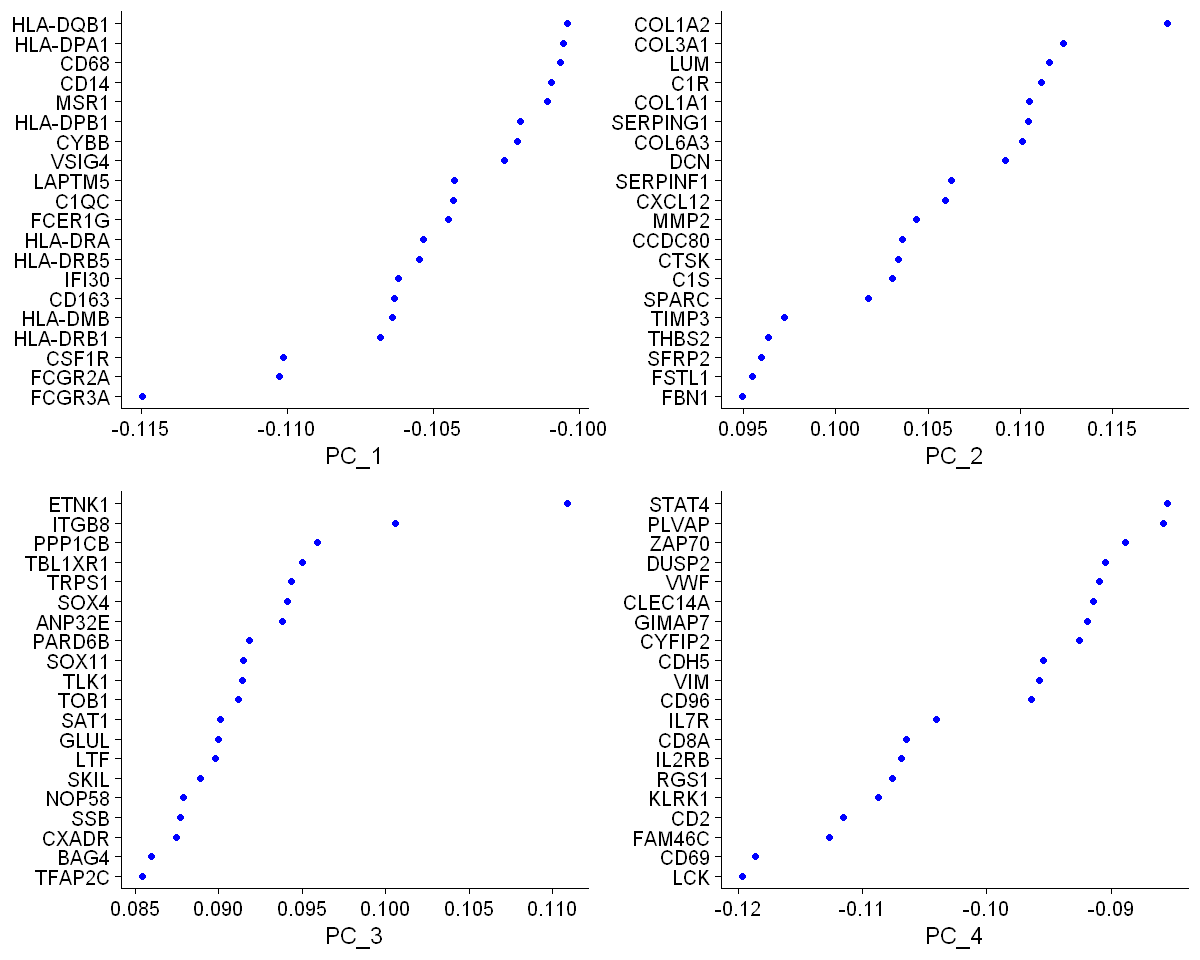

In [239]:
#测试绘图
VizDimLoadings(object = pbmc, dims = 1:4, reduction = "pca",nfeatures = 20)

- 会得到一系列的主成分，还有每种主成分相应的基因
- 查看打分的绝对值，绝对值越大，基因与该主成分越相关
- 此处选取前20个

函数的参数含义：
- dims = 1:4     复制前4个PC
- reduction = "pca"     选择降维的方法为PCA
- nfeatures = 20     选择每个PC中呈现的基因数为20个，这个可以自己调整

In [240]:
pdf(file="4.pcaGene.pdf",width=10,height=8)
VizDimLoadings(object = pbmc, dims = 1:4, reduction = "pca",nfeatures = 20)
dev.off()

png 
  2

### 主成分分析图形

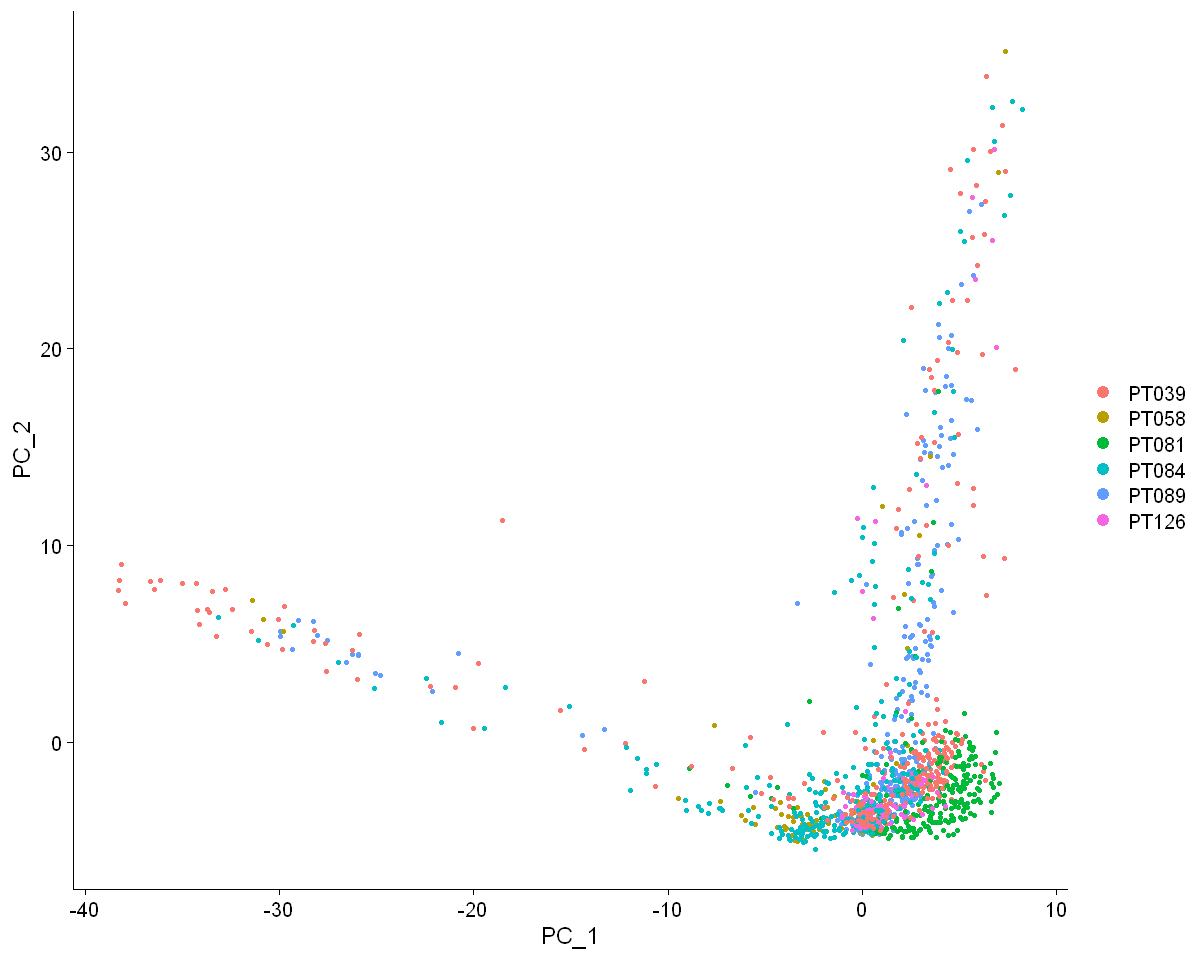

In [241]:
#绘图测试
DimPlot(object = pbmc, reduction = "pca")

- PC1与PC2的关系图
- 每种颜色代表一种细胞

In [242]:
#主成分分析图形
pdf(file="4.PCA.pdf",width=6.5,height=6)
DimPlot(object = pbmc, reduction = "pca")
dev.off()

png 
  2

### 主成分分析热图

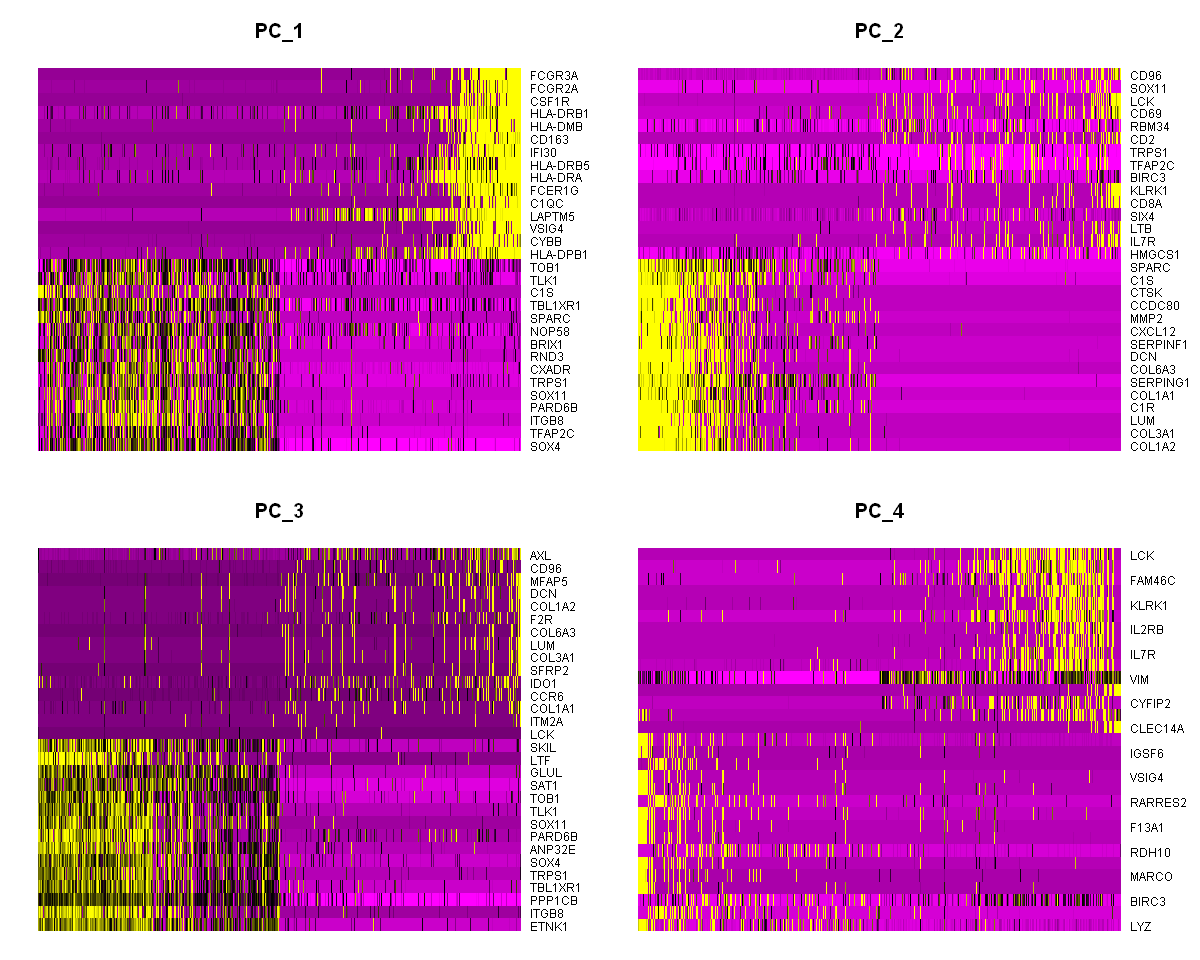

In [243]:
#绘图测试
DimHeatmap(object = pbmc, dims = 1:4, cells = 500, balanced = TRUE,nfeatures = 30,ncol=2)

- dims = 1:4    绘制前4个PC的图像
- cells = 500   
- nfeatures = 30     每个PC绘制30个基因
- ncol=2     每一行放置两张热图 

In [244]:
#主成分分析热图
pdf(file="4.pcaHeatmap.pdf",width=10,height=8)
DimHeatmap(object = pbmc, dims = 1:4, cells = 500, balanced = TRUE,nfeatures = 30,ncol=2)
dev.off()

png 
  2

### 每个PC的p值分布和均匀分布

In [245]:
#数据处理
pbmc <- JackStraw(object = pbmc, num.replicate = 100)
pbmc <- ScoreJackStraw(object = pbmc, dims = 1:20)

Warning message:
"Removed 21254 rows containing missing values (geom_point)."


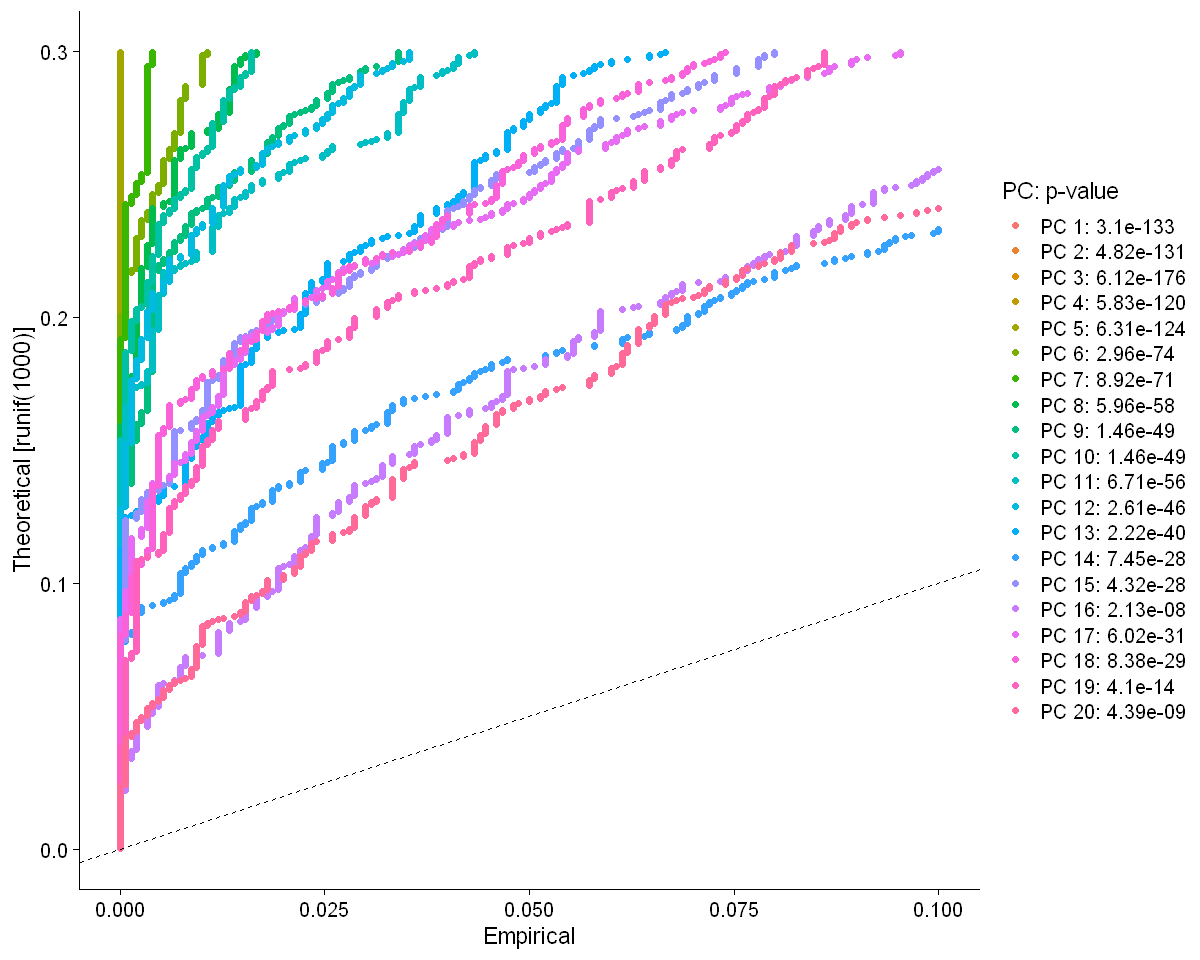

In [246]:
#绘图测试
JackStrawPlot(object = pbmc, dims = 1:20)

- 程序将数据打乱100次，然后进行模拟，计算理论值跟实际值的p-value
- 图像反映每个PC的p值
- p值越小，实际值和理论值的差异越大，PC越相关
- 筛选出p值小于0.05的PC，用于后续的tSNE聚类分析

In [247]:
pdf(file="4.pcaJackStraw.pdf",width=8,height=6)
JackStrawPlot(object = pbmc, dims = 1:20)
dev.off()

Warning message:
"Removed 21254 rows containing missing values (geom_point)."


png 
  2

# TSNE聚类分析和marker基因
## TSNE聚类分析

In [248]:
setwd('D:\\Data\\File\\单细胞测序\\scRNA-seq-Bioinformation_analyse\\5.tSNE')

In [249]:
pcSelect=20  #根据前面PCA的图像，选择p-value小于0.05的20个PC

数据处理：

In [250]:
pbmc <- FindNeighbors(object = pbmc, dims = 1:pcSelect)                #计算细胞间邻接距离
pbmc <- FindClusters(object = pbmc, resolution = 0.5)                  #对细胞分组,优化标准模块化

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1350
Number of edges: 38836

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9096
Number of communities: 15
Elapsed time: 0 seconds


- 找出细胞的相关性，然后对细胞进行分组分堆

tSNE聚类处理：

In [251]:
pbmc <- RunTSNE(object = pbmc, dims = 1:pcSelect)                      #TSNE聚类

### 对tSNE结果进行可视化操作：

The following functions and any applicable methods accept the dots: CombinePlots



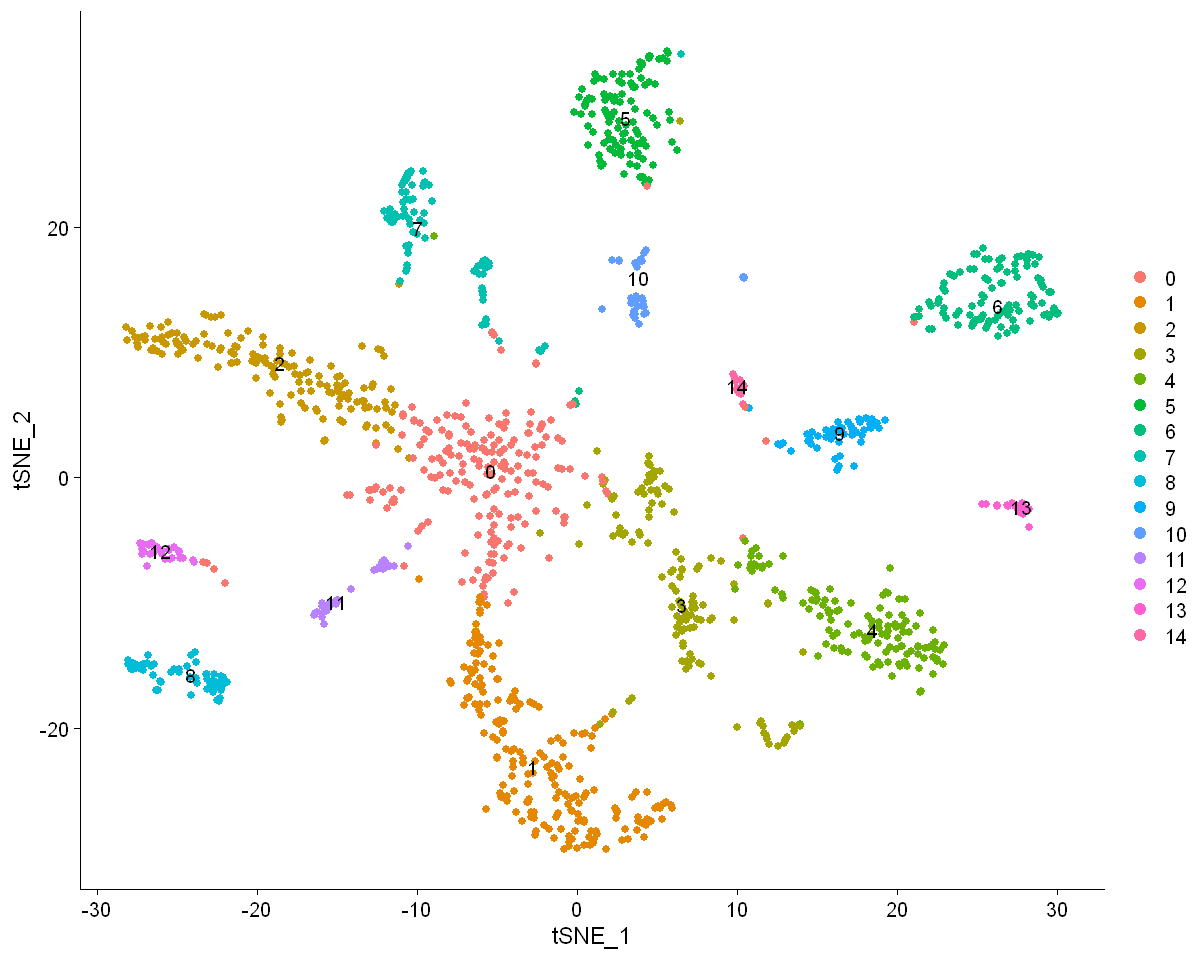

In [252]:
# 绘图测试
TSNEPlot(object = pbmc, do.label = TRUE, pt.size = 2, label = TRUE)    #TSNE可视化

- pt.size = 2 设置点的大小

In [253]:
pdf(file="5.TSNE.pdf",width=6.5,height=6)
TSNEPlot(object = pbmc, do.label = TRUE, pt.size = 2, label = TRUE)    #TSNE可视化
dev.off()

The following functions and any applicable methods accept the dots: CombinePlots



png 
  2

生成聚类结果的表格：

In [254]:
write.table(pbmc$seurat_clusters,file="5.tsneCluster.txt",quote=F,sep="\t",col.names=F)

### 寻找差异表达的特征

定义筛选条件：
- logFC的绝对值 > 0.5
- adjPval < 0.05

In [255]:
logFCfilter=0.5
adjPvalFilter=0.05

In [256]:
pbmc.markers <- FindAllMarkers(object = pbmc,
                               only.pos = FALSE,
                               min.pct = 0.25,
                               logfc.threshold = logFCfilter)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14



需要再对查找出来的差异基因结果再进行过滤操作，最后获得cluster的Marker基因：

In [257]:
sig.markers=pbmc.markers[(abs(as.numeric(as.vector(pbmc.markers$avg_logFC)))>logFCfilter & 
                          as.numeric(as.vector(pbmc.markers$p_val_adj))<adjPvalFilter),]

将筛选出来cluster的Marker基因的数据保存于表格之中：

In [258]:
write.table(sig.markers,file="5.markers.xls",sep="\t",row.names=F,quote=F) 

In [259]:
library(readxl)

In [260]:
#此表格包含所有cluster的Marker基因
read.table('5.markers.xls', sep='\t')[1:10,]

V1,V2,V3,V4,V5,V6,V7
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
3.56641666690181e-54,-1.02011964105108,0.214,0.862,6.40243120042212e-50,0,GPI
2.69178713904301e-50,-1.31671743596195,0.159,0.779,4.83229627201001e-46,0,YWHAZ
3.63305576693955e-49,-0.999824795226506,0.209,0.879,6.52206171280988e-45,0,PNPT1
9.93711670085828e-49,-0.717305093945083,0.134,0.769,1.78391119013808e-44,0,ARPP19
1.00588656795722e-48,-1.36741161843332,0.09,0.708,1.80576756679681e-44,0,DDX3X
1.46077795745018e-48,-0.575265266345034,0.144,0.775,2.62238858921457e-44,0,CACUL1
3.99778464711929e-48,-0.583420846794232,0.169,0.813,7.17682299850856e-44,0,S1PR2
4.58765460365632e-48,-0.569663831330732,0.169,0.815,8.23575754448383e-44,0,TMEM41B


### 绘制marker在各个cluster的热图
每个cluster都选择前10个基因绘制热图

In [261]:
#选择cluster的前10个Marker基因
top10 <- pbmc.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)

Warning message in DoHeatmap(object = pbmc, features = top10$gene):
"The following features were omitted as they were not found in the scale.data slot for the RNA assay: SSR4, ITM2C, PIM2, MZB1, DST, CSRP1, CDH3, MYLK, ELOVL5, AZGP1, SLC39A6, TSC22D3, TNFAIP3, CXCR4, CORO1A, PTPRC, IL2RG, MGP, DSC2, FAM60A, LRP6, KIT, TRIM2, NDRG2, CALML5, KRT19, CLDN3, CLDN4, TACSTD2, GABRP, DPY19L2P2, L2HGDH, YIF1A, SHISA9, BRIP1, LINC00294, ZNF526, DCUN1D1, FOXK1, METTL21A, PSMD10, DDAH2, SNRPD1, BNIP3L, SEC61G, OS9, NDUFC1, UGDH"


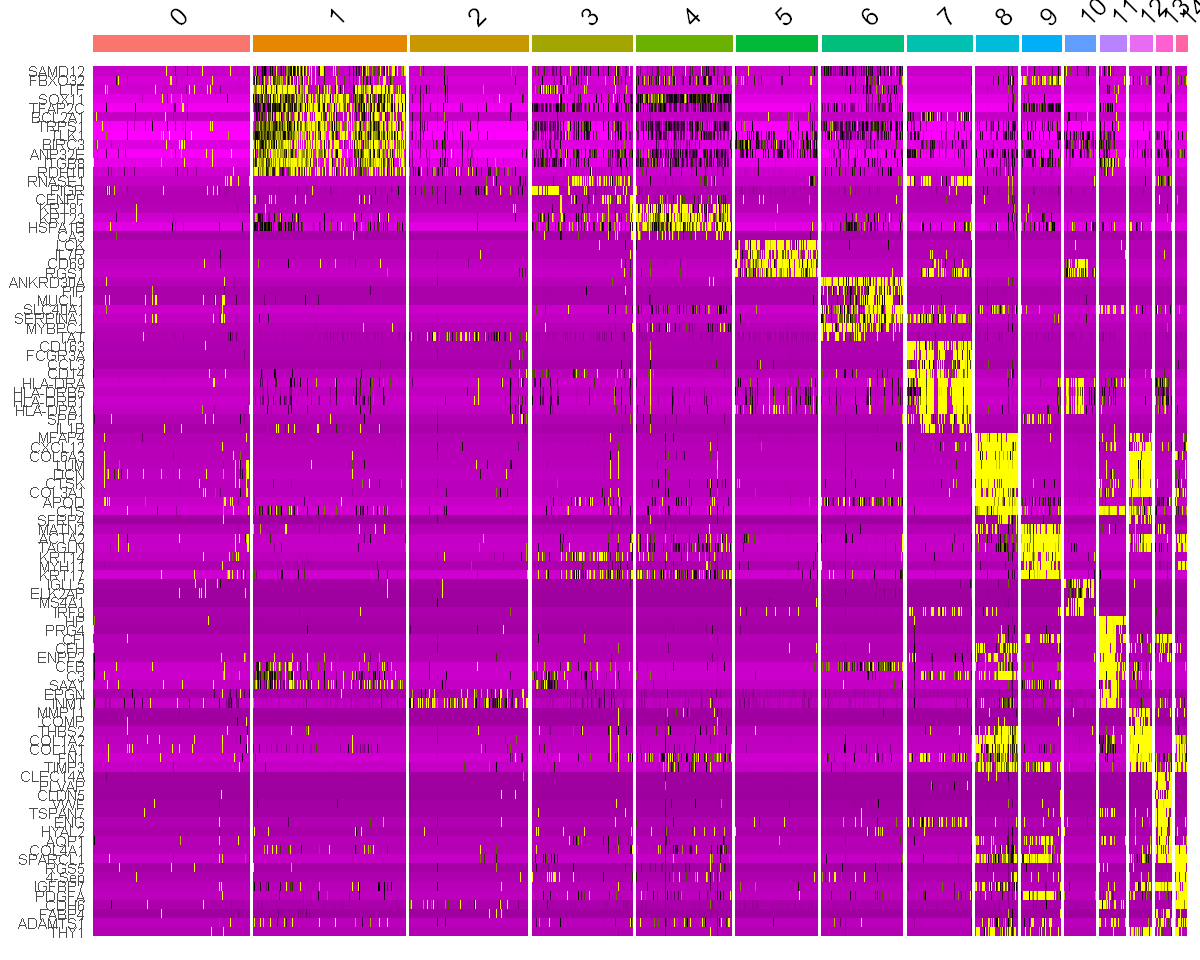

In [262]:
# 测试绘图
DoHeatmap(object = pbmc, features = top10$gene) + NoLegend()

In [263]:
#绘制marker的小提琴图
pdf(file="5.markerViolin.pdf",width=10,height=6)
VlnPlot(object = pbmc, features = c("IGLL5", "MBOAT1"))
dev.off()

png 
  2

### 绘制marker的小提琴图

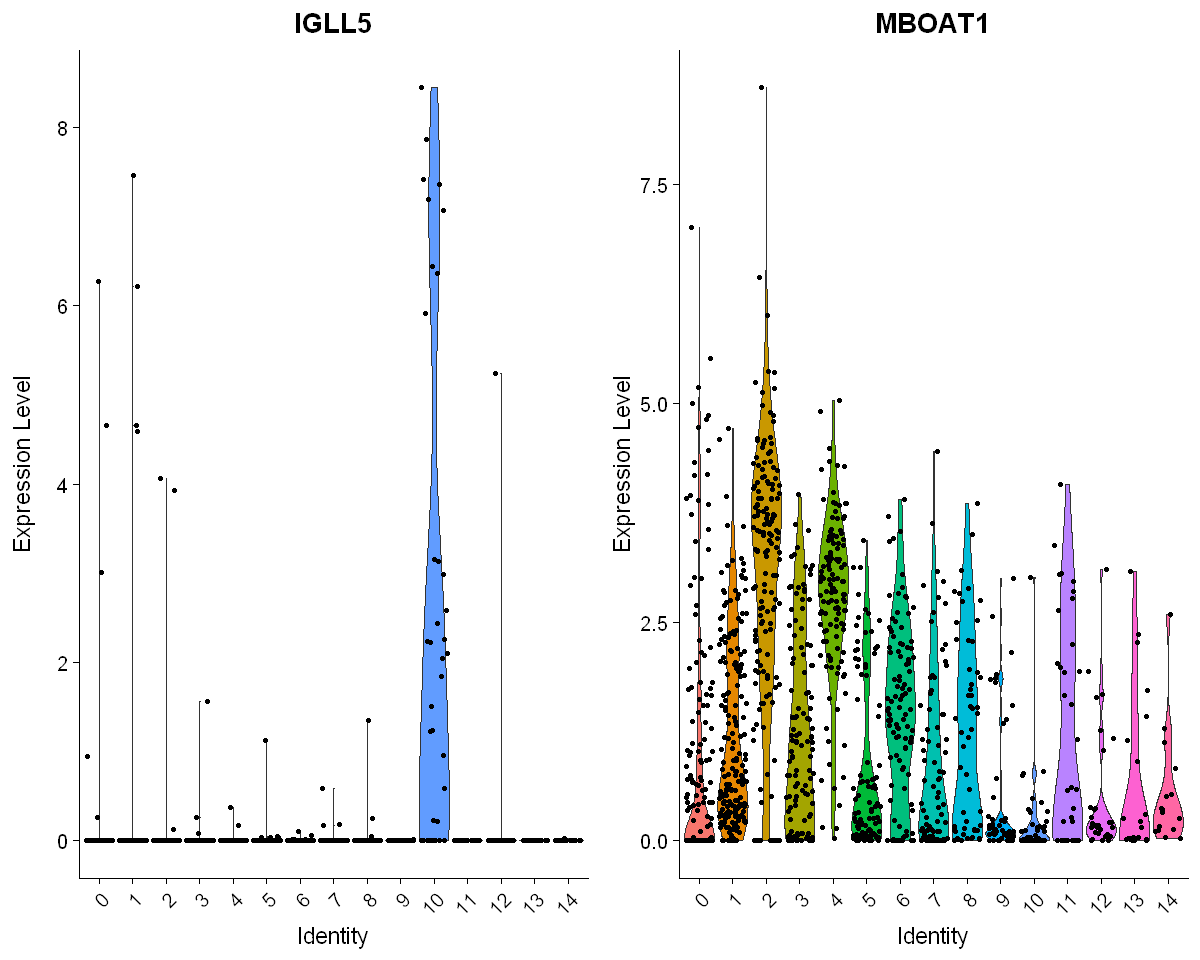

In [264]:
#测试绘图
VlnPlot(object = pbmc, features = c("IGLL5", "MBOAT1"))

- features = c(<关注的基因>)
- 关注的基因可以选择那些在cluster中的logFC最大和最小的基因
- 例如，此处选择cluster10中，logFC最大和最小的基因"IGLL5", "MBOAT1"
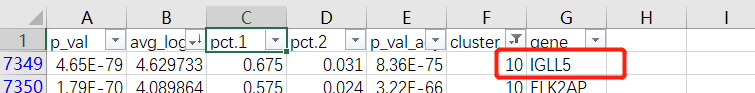

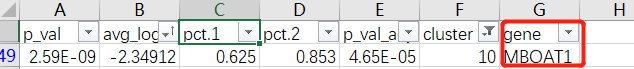

In [265]:
#绘制marker的小提琴图
pdf(file="5.markerViolin.pdf",width=10,height=6)
VlnPlot(object = pbmc, features = c("IGLL5", "MBOAT1"))
dev.off()

png 
  2

### 绘制marker基因在各个cluster的散点图

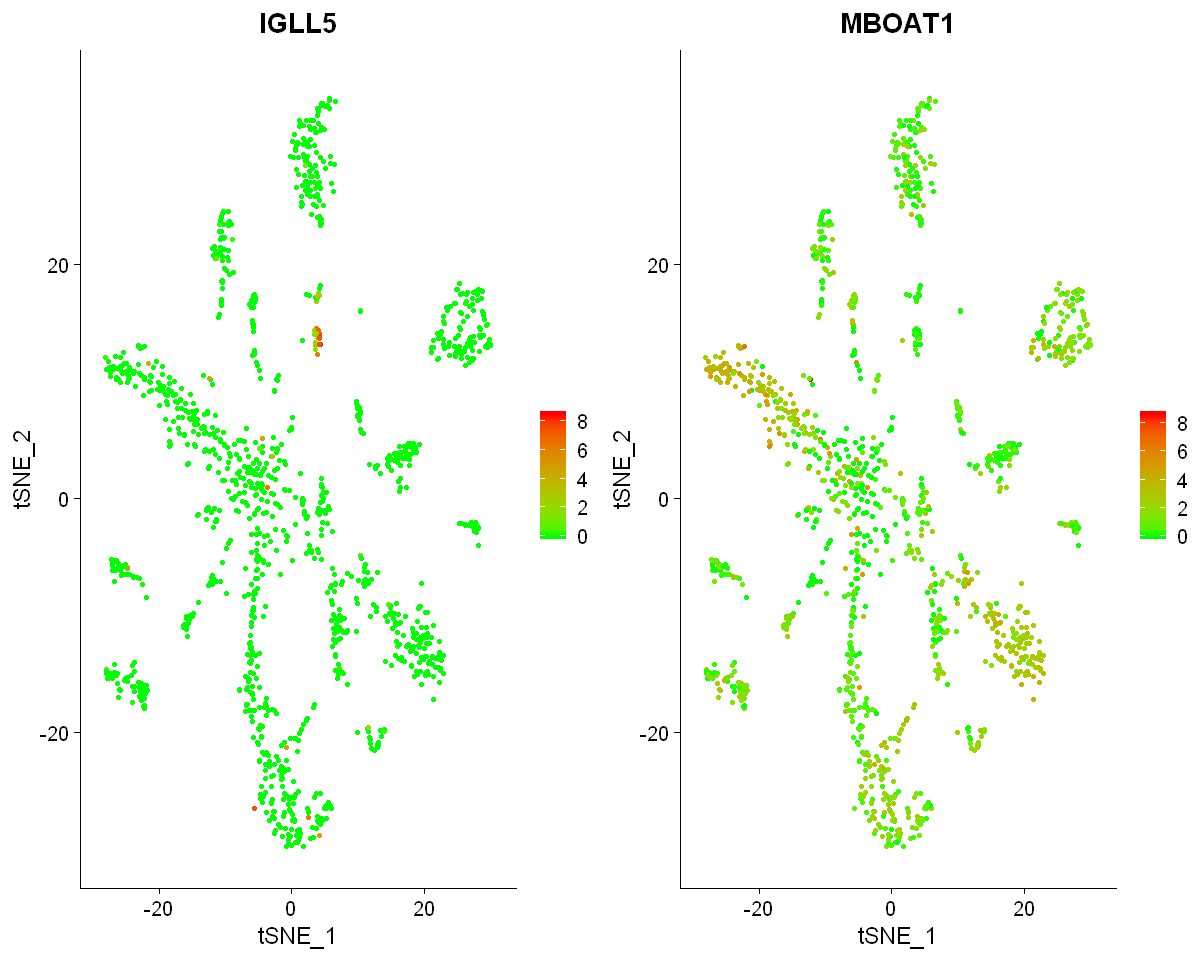

In [266]:
#测试
FeaturePlot(object = pbmc, features = c("IGLL5", "MBOAT1"),cols = c("green", "red"))

In [267]:
#绘制marker在各个cluster的散点图
pdf(file="5.markerScatter.pdf",width=10,height=6)
FeaturePlot(object = pbmc, features = c("IGLL5", "MBOAT1"),cols = c("green", "red"))
dev.off()

png 
  2

### 绘制marker在各个cluster的气泡图

In [268]:
#选择感兴趣的Marker基因，此处选择的是cluster10的Marker基因（avg_logFC值最大的5个和最小的5个)
cluster10Marker=c("MBOAT1", "NFIB", "TRPS1", "SOX4", "CNN3", "PIM2", "MZB1", "MS4A1", "ELK2AP", "IGLL5")

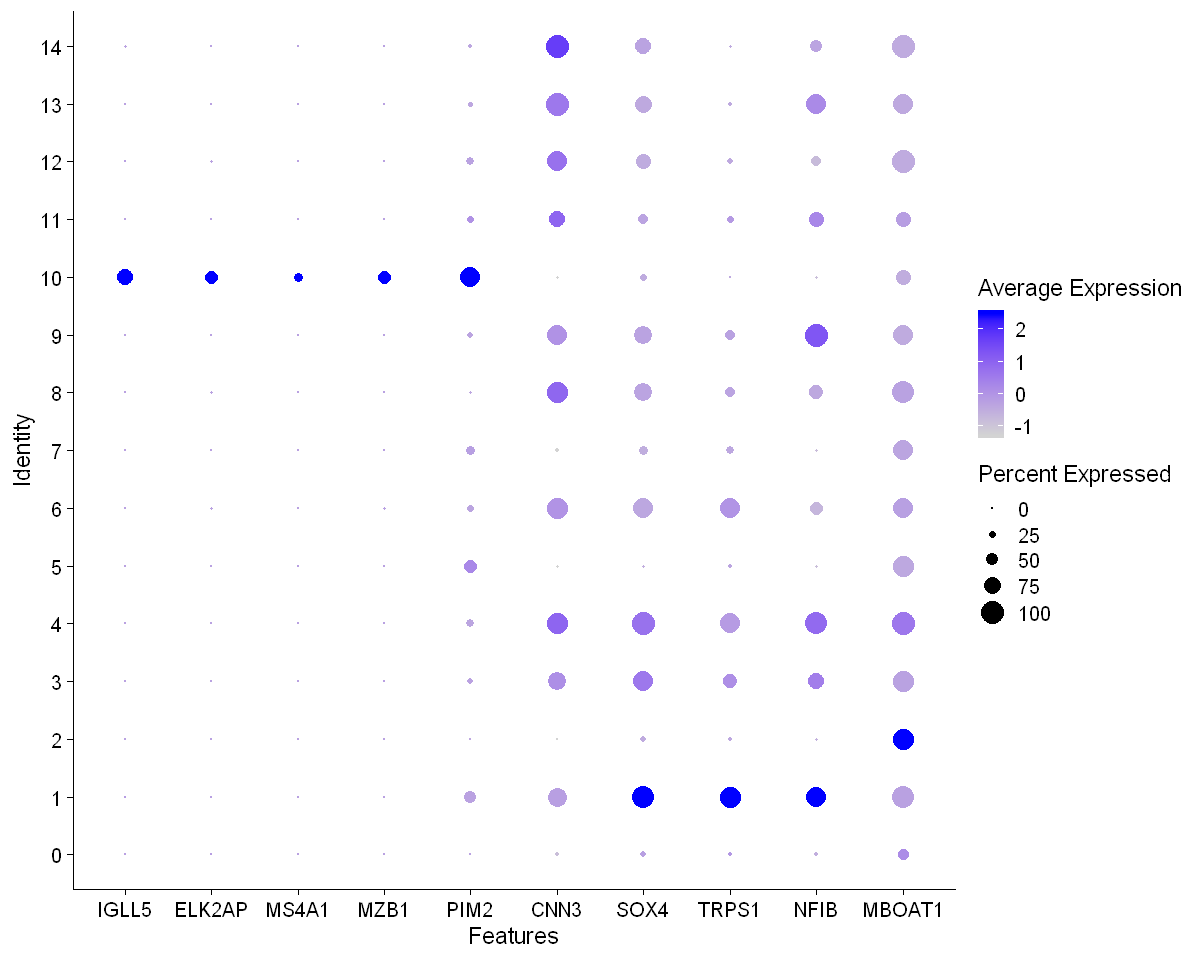

In [269]:
#测试绘图
DotPlot(object = pbmc, features = cluster10Marker)

In [270]:
#绘制marker在各个cluster的气泡图
pdf(file="5.markerBubble.pdf",width=12,height=6)
DotPlot(object = pbmc, features = cluster10Marker)
dev.off()

png 
  2

# 注释细胞类型
单细胞测序与转录组测序的区别：
- 转录组测序是将正常细胞和异常细胞进行整体的区分
- 单细胞测序则是，通过在异常细胞中通过聚类，细分，检查这些细胞是否具有差异，做差异分析，找到Marker基因

难点在于：
- 需要结合软件预测和疾病新型的相关知识

In [271]:
setwd('D:\\Data\\File\\单细胞测序\\scRNA-seq-Bioinformation_analyse\\6.Annotation of cell atlases')

## 对细胞进行注释

In [272]:
library(SingleR)

构建SingleR的输入文件：

In [273]:
counts<-pbmc@assays$RNA@counts
clusters<-pbmc@meta.data$seurat_clusters #每个细胞所在的cluster信息
ann=pbmc@meta.data$orig.ident   #注释文件 每个细胞的来源

In [274]:
head(ann)

[1] PT089 PT089 PT089 PT089 PT089 PT089
Levels: PT039 PT058 PT081 PT084 PT089 PT126

### 构建细胞注释的SingleR对象

In [275]:
singler = CreateSinglerObject(counts, annot = ann, "pbmc", min.genes = 0,
            species = "Human", citation = "",
            ref.list = list(), normalize.gene.length = F, variable.genes = "de",
            fine.tune = F, do.signatures = T, clusters = clusters, do.main.types = T,
            reduce.file.size = T, numCores = 1)

[1] "Dimensions of counts data: 17952x1350"
[1] "Annotating data with HPCA..."
[1] "Variable genes method: de"
[1] "Number of DE genes:4045"
[1] "Number of cells: 1350"
[1] "Number of DE genes:4045"
[1] "Number of clusters: 15"
[1] "Annotating data with HPCA (Main types)..."
[1] "Number of DE genes:3063"
[1] "Number of cells: 1350"
[1] "Number of DE genes:3063"
[1] "Number of clusters: 15"
[1] "Annotating data with Blueprint_Encode..."
[1] "Variable genes method: de"
[1] "Number of DE genes:3706"
[1] "Number of cells: 1350"
[1] "Number of DE genes:3706"
[1] "Number of clusters: 15"
[1] "Annotating data with Blueprint_Encode (Main types)..."
[1] "Number of DE genes:3146"
[1] "Number of cells: 1350"
[1] "Number of DE genes:3146"
[1] "Number of clusters: 15"


Warning message in cor(cell.type.classification$cell.types.avg[A, ], as.matrix(sc.data[A, :
"标准差为零"


- count: 基因表达量
- annot = ann ：细胞来源于哪个样品的信息
- 每个细胞至少的基因表达数，因为前面已经过滤了，此处无需过滤
- fine.tune = F：若为T，则进行基因系的计算，但时间非常慢
- clusters = clusters 每个样品所属于的cluster信息
- numCores = 1：CPU的核心数，若不是1比较容易出错

### 定义singler的seurat对象

In [276]:
singler$seurat = pbmc

### 定义singler的meta对象的坐标

In [277]:
singler$meta.data$xy = pbmc@reductions$tsne@cell.embeddings

### 保存cluster和细胞的注释文件

In [278]:
clusterAnn=singler$singler[[2]]$SingleR.clusters.main$labels #从singler对象中提取cluster注释信息
write.table(clusterAnn,file="6.clusterAnn.txt",quote=F,sep="\t",col.names=F) #保存cluster的注释文件
write.table(singler$other,file="6.cellAnn.txt",quote=F,sep="\t",col.names=F) #保存细胞的注释文件

结果展示：

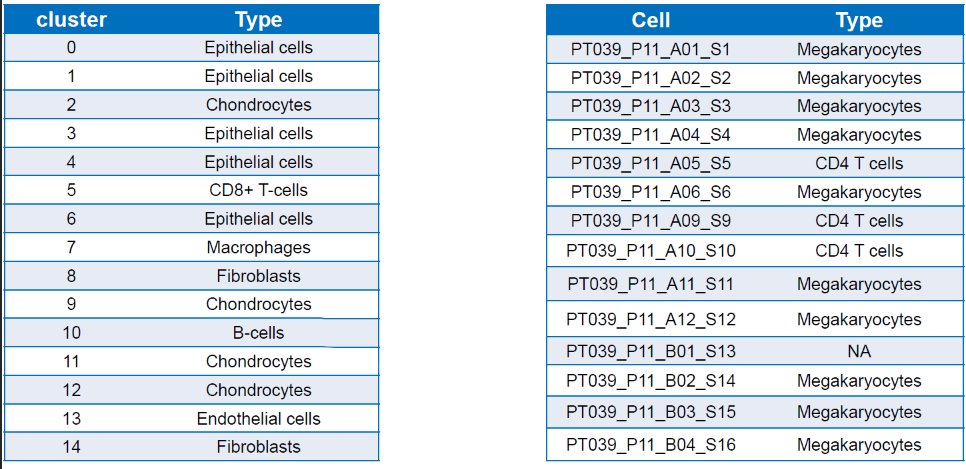

# 细胞轨迹分析

## 准备monocle分析需要的文件
用于计算细胞轨迹分析的输入文件

In [279]:
setwd('D:\\Data\\File\\单细胞测序\\scRNA-seq-Bioinformation_analyse\\7.Cell trajectory analysis')

In [280]:
#构建行名是基因名，列名是样品名的矩阵文件
monocle.matrix=as.matrix(pbmc@assays$RNA@data) 
monocle.matrix=cbind(id=row.names(monocle.matrix),monocle.matrix)
write.table(monocle.matrix,file="7.monocleMatrix.txt",quote=F,sep="\t",row.names=F)

In [281]:
#构造样品文件，说明哪些细胞来源于哪些样品
monocle.sample=as.matrix(pbmc@meta.data)
monocle.sample=cbind(id=row.names(monocle.sample),monocle.sample)
write.table(monocle.sample,file="7.monocleSample.txt",quote=F,sep="\t",row.names=F)

In [282]:
#构造基因文件
monocle.geneAnn=data.frame(gene_short_name = row.names(monocle.matrix), row.names = row.names(monocle.matrix))
monocle.geneAnn=cbind(id=row.names(monocle.geneAnn),monocle.geneAnn)
write.table(monocle.geneAnn,file="7.monocleGene.txt",quote=F,sep="\t",row.names=F)

- 此处只有基因名，没有其他信息，作为后续的注释文件

In [283]:
#构造cluster与细胞对应的注释文件
write.table(clusterAnn,file="7.monocleClusterAnn.txt",quote=F,sep="\t",col.names=F)
#构造Marker基因文件
write.table(sig.markers,file="7.monocleMarkers.txt",sep="\t",row.names=F,quote=F)

## 运行细胞轨迹分析程序
### 安装包

```
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("monocle")

library(monocle)
```

In [208]:
library(monocle)

### 数据读入

In [298]:
monocle.matrix=read.table("7.monocleMatrix.txt",sep="\t",header=T,row.names=1,check.names=F)
monocle.sample=read.table("7.monocleSample.txt",sep="\t",header=T,row.names=1,check.names=F)
monocle.geneAnn=read.table("7.monocleGene.txt",sep="\t",header=T,row.names=1,check.names=F)  #主要是为了转换Ensambl id到基因名

只选择Marker基因进行分析：

In [307]:
marker=read.table("7.monocleMarkers.txt",sep="\t",header=T,check.names=F)

### 将Seurat结果转换为monocle需要的细胞矩阵，输入细胞注释表和基因注释表

In [309]:
data <- as(as.matrix(monocle.matrix), 'sparseMatrix')
pd<-new("AnnotatedDataFrame", data = monocle.sample)
fd<-new("AnnotatedDataFrame", data = monocle.geneAnn)

### 构建出monocle的对象

In [312]:
cds <- newCellDataSet(data, phenoData = pd, featureData = fd)

### 对构建出monocle的对象的cluster重新命名其列名：

In [313]:
#给其中一列数据重命名
names(pData(cds))[names(pData(cds))=="seurat_clusters"]="Cluster"

In [314]:
head(pData(cds))

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.5,Cluster,Size_Factor
,<fct>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
PT089_P1_A01,PT089,2110870.4,3553,0,11,11,NA
PT089_P1_A02,PT089,1945622.6,3371,0,11,11,NA
PT089_P1_A03,PT089,1524090.6,2578,0,11,11,NA
PT089_P1_A04,PT089,427386.5,2260,0,7,7,NA
PT089_P1_A05,PT089,1511134.6,2657,0,7,7,NA
PT089_P1_A06,PT089,1721225.6,3179,0,11,11,NA


In [315]:
#在Cluster列的数字前面添加Cluster关键字
pData(cds)[,"Cluster"]=paste0("cluster",pData(cds)[,"Cluster"])

In [316]:
head(pData(cds))

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.5,Cluster,Size_Factor
,<fct>,<dbl>,<int>,<int>,<int>,<chr>,<dbl>
PT089_P1_A01,PT089,2110870.4,3553,0,11,cluster11,NA
PT089_P1_A02,PT089,1945622.6,3371,0,11,cluster11,NA
PT089_P1_A03,PT089,1524090.6,2578,0,11,cluster11,NA
PT089_P1_A04,PT089,427386.5,2260,0,7,cluster7,NA
PT089_P1_A05,PT089,1511134.6,2657,0,7,cluster7,NA
PT089_P1_A06,PT089,1721225.6,3179,0,11,cluster11,NA


### 添加细胞聚类的注释数据

In [317]:
#添加细胞聚类数据
clusterRt=read.table("7.monocleClusterAnn.txt",header=F,sep="\t",check.names=F)

In [319]:
clusterRt

V1,V2
<int>,<fct>
0,Epithelial cells
1,Epithelial cells
2,Chondrocytes
3,Epithelial cells
4,Epithelial cells
5,CD8+ T-cells
6,Epithelial cells
7,Macrophages
8,Fibroblasts


In [318]:
clusterAnn=as.character(clusterRt[,2])

In [320]:
clusterAnn

[1] "Epithelial cells"  "Epithelial cells"  "Chondrocytes"     
 [4] "Epithelial cells"  "Epithelial cells"  "CD8+ T-cells"     
 [7] "Epithelial cells"  "Macrophages"       "Fibroblasts"      
[10] "Chondrocytes"      "B-cells"           "Chondrocytes"     
[13] "Chondrocytes"      "Endothelial cells" "Fibroblasts"

In [321]:
names(clusterAnn)=paste0("cluster",clusterRt[,1])

In [322]:
clusterAnn

cluster0            cluster1            cluster2            cluster3 
 "Epithelial cells"  "Epithelial cells"      "Chondrocytes"  "Epithelial cells" 
           cluster4            cluster5            cluster6            cluster7 
 "Epithelial cells"      "CD8+ T-cells"  "Epithelial cells"       "Macrophages" 
           cluster8            cluster9           cluster10           cluster11 
      "Fibroblasts"      "Chondrocytes"           "B-cells"      "Chondrocytes" 
          cluster12           cluster13           cluster14 
     "Chondrocytes" "Endothelial cells"       "Fibroblasts"

In [323]:
pData(cds)$cell_type2 <- plyr::revalue(as.character(pData(cds)$Cluster),clusterAnn) #将聚类数据转换成细胞类型数据

In [328]:
head(pData(cds))

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.5,Cluster,Size_Factor,cell_type2
,<fct>,<dbl>,<int>,<int>,<int>,<chr>,<dbl>,<chr>
PT089_P1_A01,PT089,2110870.4,3553,0,11,cluster11,1.706335,Chondrocytes
PT089_P1_A02,PT089,1945622.6,3371,0,11,cluster11,1.594381,Chondrocytes
PT089_P1_A03,PT089,1524090.6,2578,0,11,cluster11,1.235999,Chondrocytes
PT089_P1_A04,PT089,427386.5,2260,0,7,cluster7,1.428380,Macrophages
PT089_P1_A05,PT089,1511134.6,2657,0,7,cluster7,1.203185,Macrophages
PT089_P1_A06,PT089,1721225.6,3179,0,11,cluster11,1.451543,Chondrocytes


### 伪时间分析流程

In [326]:
#数据校正，R包作者强调这一步必须做
cds <- estimateSizeFactors(cds)
cds <- estimateDispersions(cds)

Removing 472 outliers



In [331]:
cds <- setOrderingFilter(cds, marker$gene) #只保留Marker基因

In [334]:
cds

CellDataSet (storageMode: environment)
assayData: 17952 features, 1350 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: PT089_P1_A01 PT089_P1_A02 ... PT039_P10_H12_S288 (1350
    total)
  varLabels: orig.ident nCount_RNA ... cell_type2 (8 total)
  varMetadata: labelDescription
featureData
  featureNames: A1BG A1BG-AS1 ... ZZZ3 (17952 total)
  fvarLabels: gene_short_name use_for_ordering
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Transformation introduced infinite values in continuous y-axis"


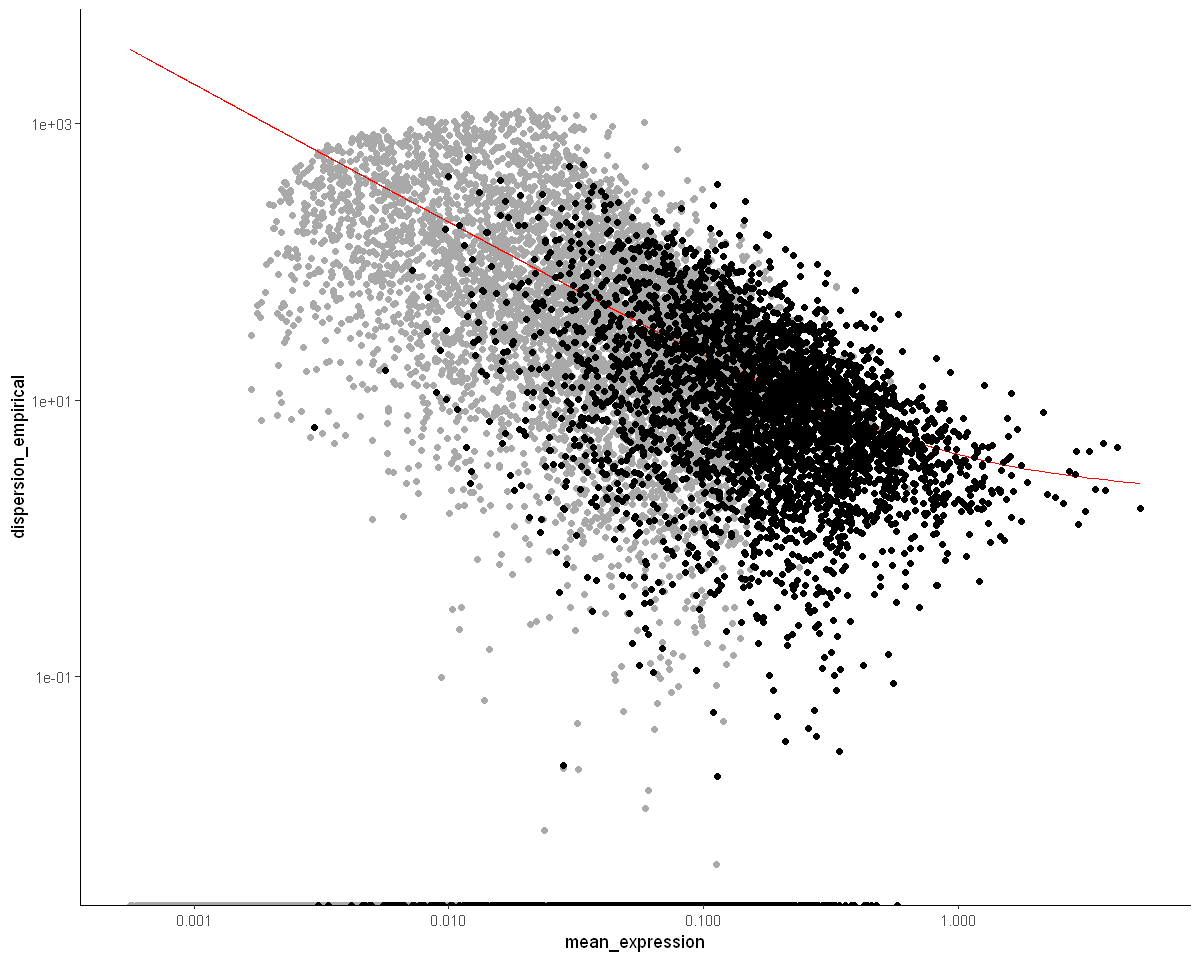

In [335]:
#检查一下校正后的数据分布
plot_ordering_genes(cds)

**对数据再进行一次降维：降到只有两维**

In [336]:
cds <- reduceDimension(cds, max_components = 2,reduction_method = 'DDRTree') #数据降维到2维
cds <- orderCells(cds) #对细胞进行排序,形成树的轮廓

**绘制聚类的细胞轨迹图形：**
1. 聚类cluster的细胞轨迹图形

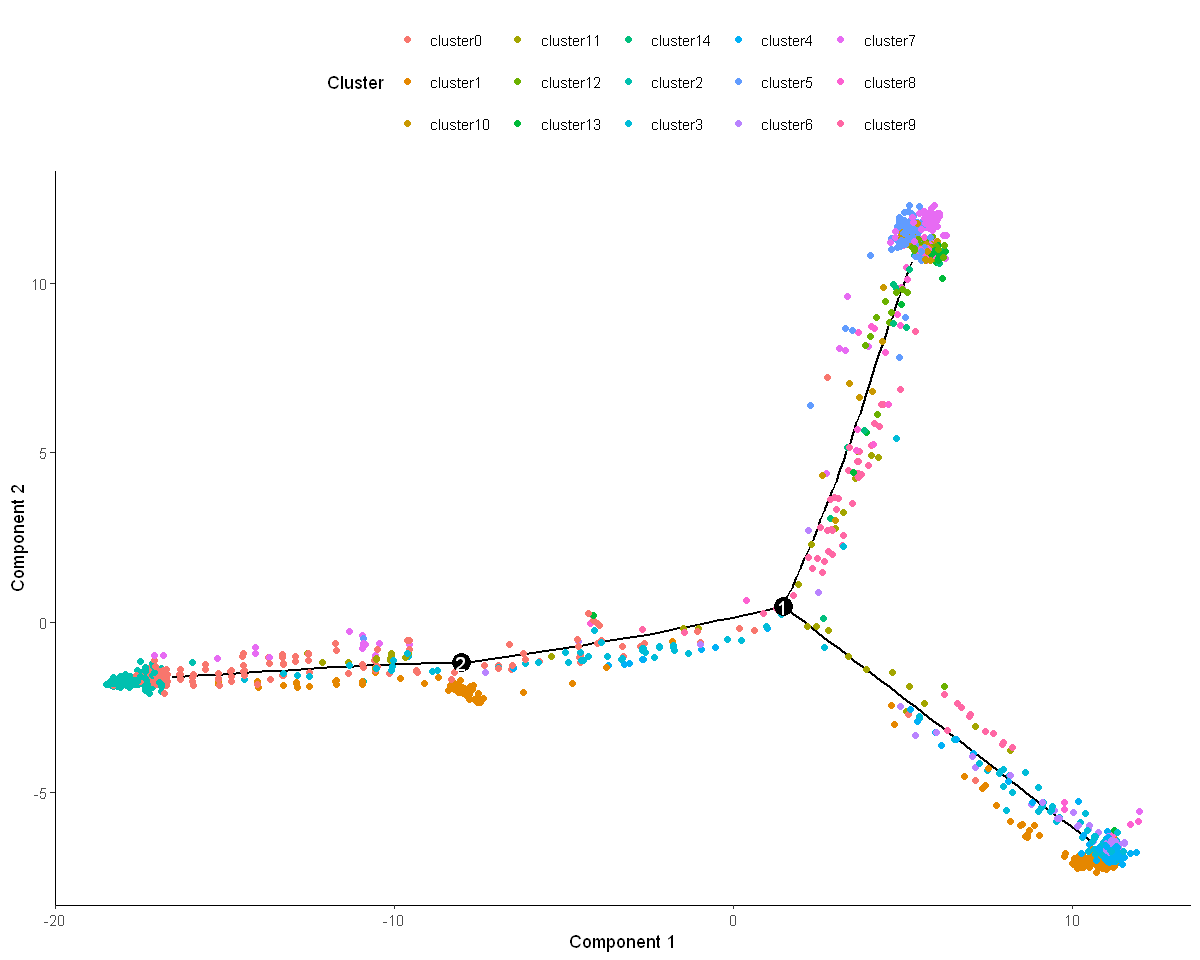

In [338]:
#绘图测试 
plot_cell_trajectory(cds, color_by = "Cluster")

In [340]:
pdf(file="7.cluster.trajectory.pdf",width=6.5,height=6)
plot_cell_trajectory(cds, color_by = "Cluster")
dev.off()

png 
  2

2. 绘制细胞类型的细胞轨迹图：

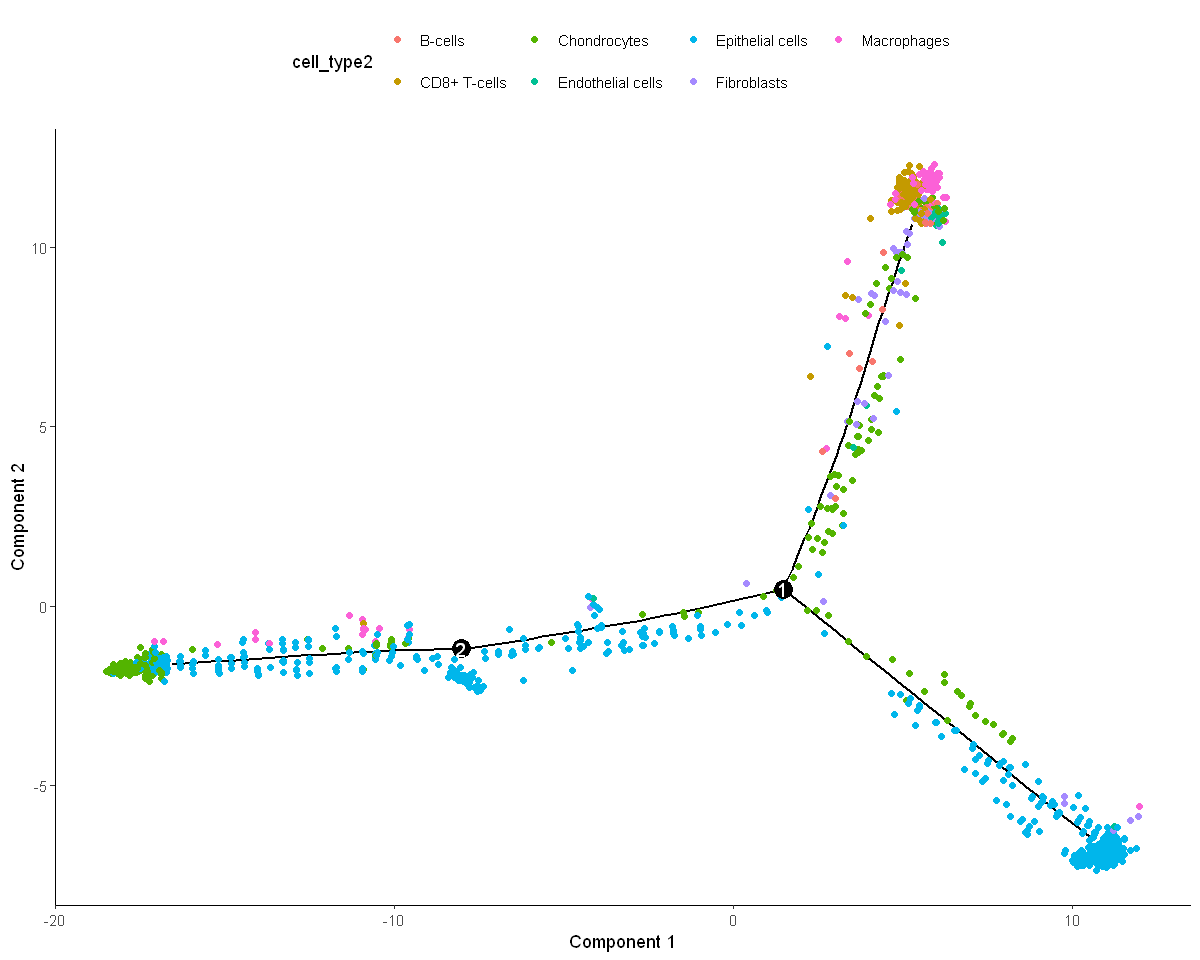

In [339]:
#绘图测试：
plot_cell_trajectory(cds,color_by = "cell_type2")

In [341]:
pdf(file="7.cellType.trajectory.pdf",width=6.5,height=6)
plot_cell_trajectory(cds,color_by = "cell_type2")
dev.off()

png 
  2

# marker基因id转换

## 选择Marker基因
- 将`5.markers.xls`复制到新建的文件夹`D:\Data\File\单细胞测序\scRNA-seq-Bioinformation_analyse\8.symbo2id`
- 此处以选择cluster10的Marker基因为例：
    - 在目录中鼠标右键——打开git bash或者Windows的Linux子系统，输入：
    ```
    $ awk -F'\t' '$6==10 || NR==1{print $0}'  5.markers.xls > 8.cluster10_Marker.xls
     ```
     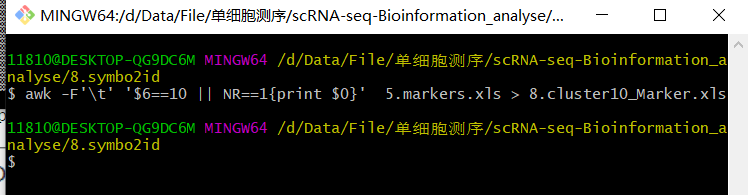

## 构造输入文件
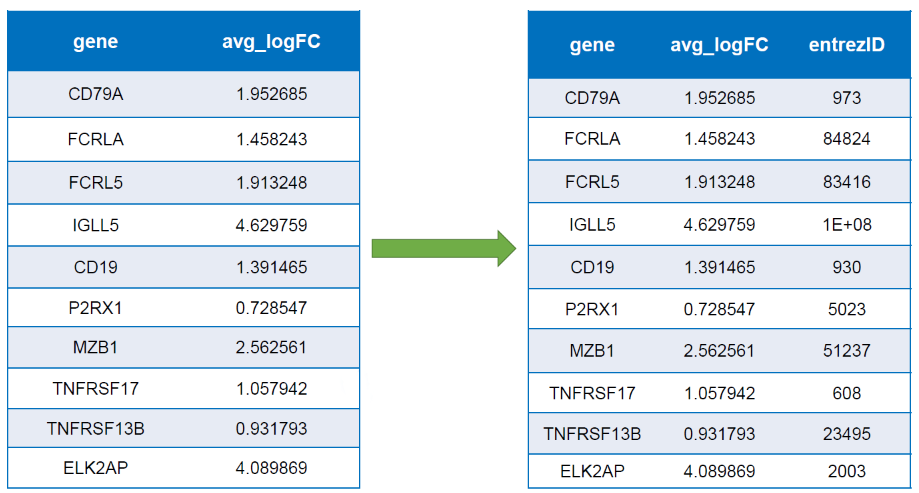
- 左边表格的格式

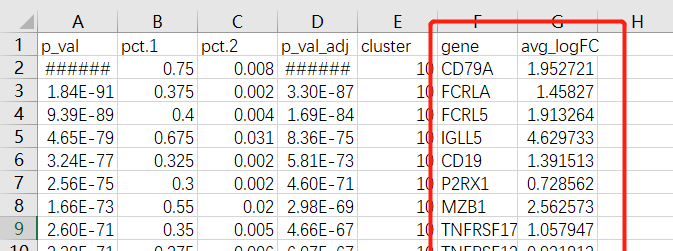

- 复制右边两列到新文本文件中，并命名为`symbol.txt`
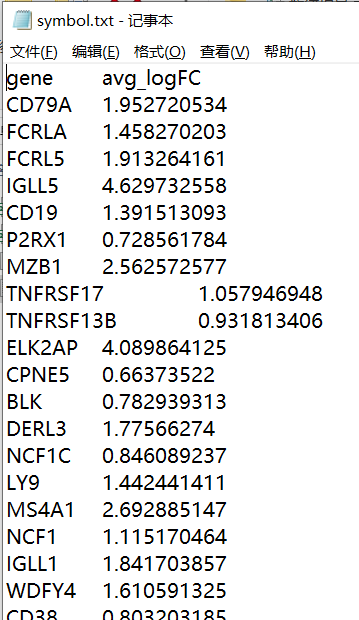

### 运行R脚本 `scRNA.symbol2id.R`

In [342]:
setwd("D:\\Data\\File\\单细胞测序\\scRNA-seq-Bioinformation_analyse\\8.symbo2id")          #设置工作目录

library("org.Hs.eg.db")          #引用包
rt=read.table("symbol.txt",sep="\t",check.names=F,header=T)    #读取文件
genes=as.vector(rt[,1])
entrezIDs <- mget(genes, org.Hs.egSYMBOL2EG, ifnotfound=NA)    #找出基因对应的id
entrezIDs <- as.character(entrezIDs)
out=cbind(rt,entrezID=entrezIDs)
write.table(out,file="id.txt",sep="\t",quote=F,row.names=F)    #输出结果

Loading required package: AnnotationDbi

Loading required package: IRanges

Loading required package: S4Vectors


Attaching package: 'S4Vectors'


The following object is masked from 'package:Matrix':

    expand


The following objects are masked from 'package:dplyr':

    first, rename


The following object is masked from 'package:base':

    expand.grid



Attaching package: 'IRanges'


The following objects are masked from 'package:dplyr':

    collapse, desc, slice


The following object is masked from 'package:grDevices':

    windows



Attaching package: 'AnnotationDbi'


The following object is masked from 'package:dplyr':

    select






得到结果文件:
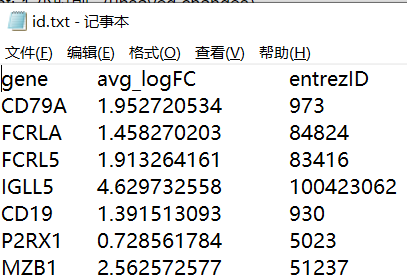

# GO富集分析

In [348]:
library("clusterProfiler")
library("org.Hs.eg.db")
library("enrichplot")
library("ggplot2")



Registered S3 method overwritten by 'enrichplot':
  method               from
  fortify.enrichResult DOSE

clusterProfiler v3.12.0  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.



In [346]:
setwd("D:\\Data\\File\\单细胞测序\\scRNA-seq-Bioinformation_analyse\\9.GO")                   #设置工作目录
rt=read.table("id.txt",sep="\t",header=T,check.names=F)           #读取id.txt文件
rt=rt[is.na(rt[,"entrezID"])==F,]                                 #去除基因id为NA的基因
gene=rt$entrezID

In [349]:
kk <- enrichGO(gene = gene,
               OrgDb = org.Hs.eg.db,   #选择数据库
               pvalueCutoff =0.05, 
               qvalueCutoff = 0.05,
               ont="all",             #对三大类都进行富集
               readable =T)           #结果以基因名的形式展示
write.table(kk,file="GO.txt",sep="\t",quote=F,row.names = F)                 #保存富集结果

## 柱状图

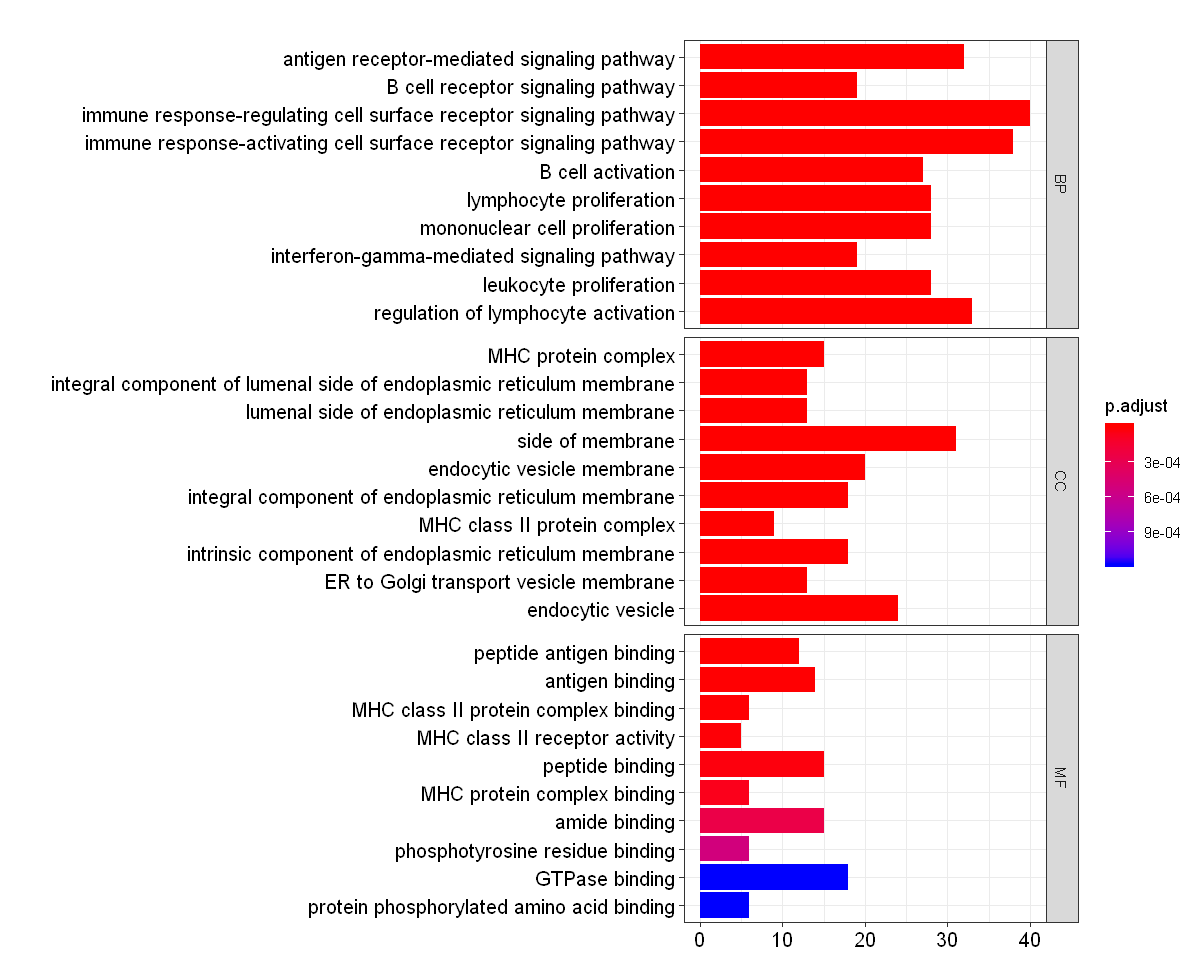

In [351]:
#绘图测试
barplot(kk, drop = TRUE, showCategory =10,split="ONTOLOGY") + facet_grid(ONTOLOGY~., scale='free')

In [352]:
#柱状图
pdf(file="9.barplot.pdf",width = 10,height = 8)
barplot(kk, drop = TRUE, showCategory =10,split="ONTOLOGY") + facet_grid(ONTOLOGY~., scale='free')
dev.off()

png 
  2

## 气泡图

wrong orderBy parameter; set to default `orderBy = "x"`



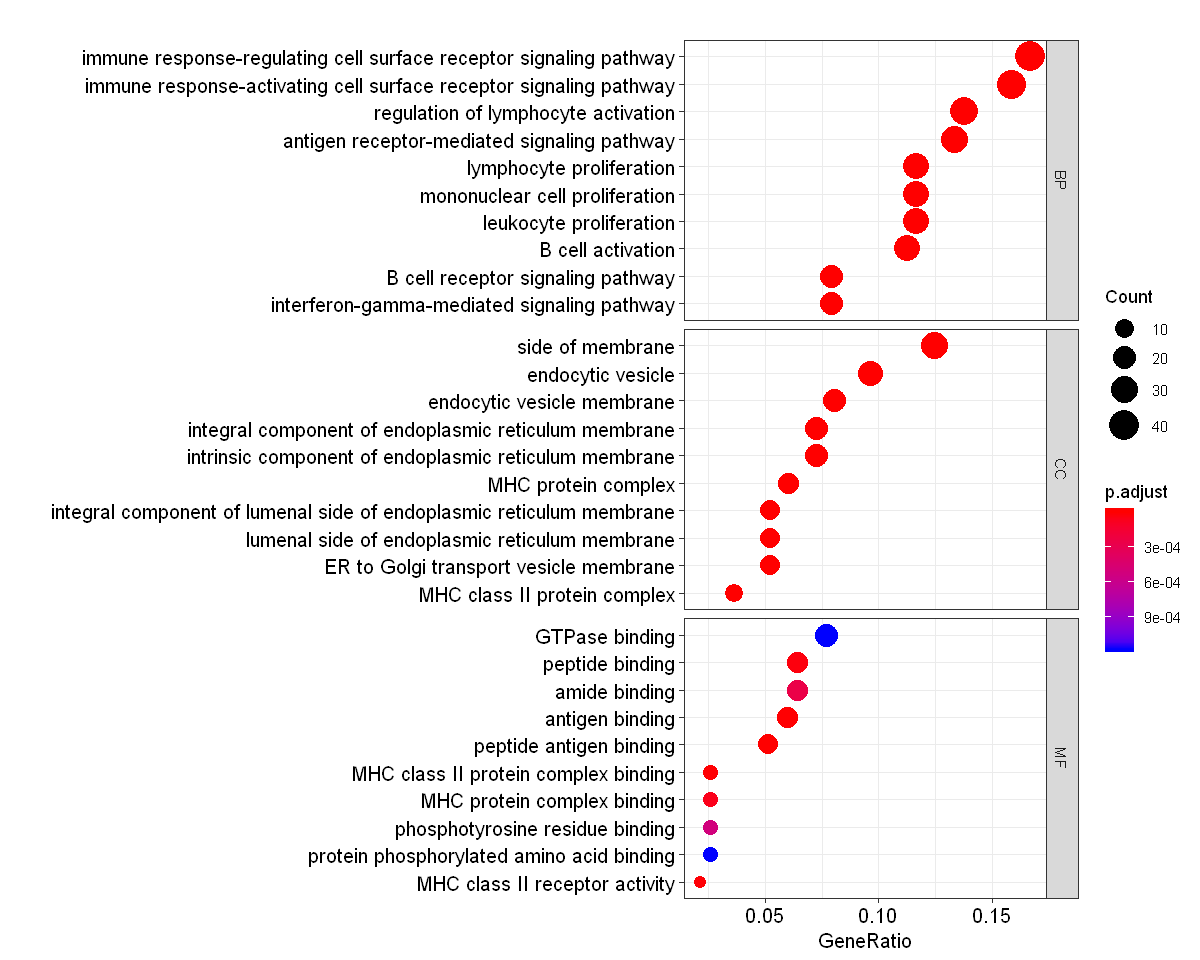

In [353]:
#绘图测试
dotplot(kk,showCategory = 10,split="ONTOLOGY") + facet_grid(ONTOLOGY~., scale='free')

In [354]:
#气泡图
pdf(file="9.bubble.pdf",width = 10,height = 8)
dotplot(kk,showCategory = 10,split="ONTOLOGY") + facet_grid(ONTOLOGY~., scale='free')
dev.off()

wrong orderBy parameter; set to default `orderBy = "x"`



png 
  2

结果文件：
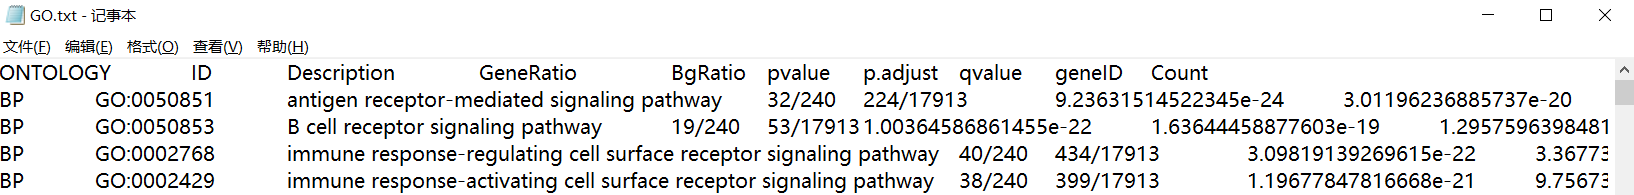

## 圈图

In [355]:
library(GOplot)
setwd("D:\\Data\\File\\单细胞测序\\scRNA-seq-Bioinformation_analyse\\9.GO")              #设置工作目录

Loading required package: ggdendro

Loading required package: gridExtra


Attaching package: 'gridExtra'


The following object is masked from 'package:Biobase':

    combine


The following object is masked from 'package:BiocGenerics':

    combine


The following object is masked from 'package:dplyr':

    combine


Loading required package: RColorBrewer



### 读取GO富集结果文件

In [356]:
ego=read.table("GO.txt", header = T,sep="\t",check.names=F)      #读取GO富集结果文件
go=data.frame(Category = "All",ID = ego$ID,Term = ego$Description, Genes = gsub("/", ", ", ego$geneID), adj_pval = ego$p.adjust)

In [358]:
head(go)

Category,ID,Term,Genes,adj_pval
<fct>,<fct>,<fct>,<fct>,<dbl>
All,GO:0050851,antigen receptor-mediated signaling pathway,"CD79A, CD19, BLK, MS4A1, CD38, STAP1, BTK, MEF2C, LAT2, PLCG2, HLA-DQA1, NCKAP1L, FCGR2B, LIME1, PTPRC, HLA-DPA1, PTPN6, PRKCB, PSMB8, ELF1, PDE4B, LPXN, INPP5D, PSMB9, HLA-DRA, KLHL6, THEMIS2, HLA-DRB1, HLA-DQB1, HLA-DPB1, EZR, SYK",3.011962e-20
All,GO:0050853,B cell receptor signaling pathway,"CD79A, CD19, BLK, MS4A1, CD38, STAP1, BTK, MEF2C, LAT2, PLCG2, NCKAP1L, FCGR2B, PTPRC, PTPN6, PRKCB, ELF1, LPXN, KLHL6, SYK",1.636445e-19
All,GO:0002768,immune response-regulating cell surface receptor signaling pathway,"CD79A, CD19, BLK, MS4A1, CD38, STAP1, BTK, ICAM3, MEF2C, LAT2, PLCG2, HLA-DQA1, NCKAP1L, FCGR2B, LIME1, GRB2, RAPGEF1, PTPRC, HLA-DPA1, PTPN6, PRKCB, PSMB8, ELF1, PDE4B, LPXN, INPP5D, PSMB9, ICAM2, HLA-DRA, ELMO1, KLHL6, THEMIS2, HLA-DRB1, HLA-DQB1, CD40, HLA-DPB1, CALM1, EZR, SYK, CYFIP2",3.367734e-19
All,GO:0002429,immune response-activating cell surface receptor signaling pathway,"CD79A, CD19, BLK, MS4A1, CD38, STAP1, BTK, ICAM3, MEF2C, LAT2, PLCG2, HLA-DQA1, NCKAP1L, FCGR2B, LIME1, GRB2, RAPGEF1, PTPRC, HLA-DPA1, PTPN6, PRKCB, PSMB8, ELF1, PDE4B, LPXN, INPP5D, PSMB9, ICAM2, HLA-DRA, ELMO1, KLHL6, THEMIS2, HLA-DRB1, HLA-DQB1, HLA-DPB1, EZR, SYK, CYFIP2",9.756737e-19
All,GO:0042113,B cell activation,"CD79A, CD19, MZB1, MS4A1, CD38, BTK, BANK1, CD27, MEF2C, LAT2, BLNK, PLCG2, CD74, ITGA4, NCKAP1L, FCGR2B, PTPRC, PTPN6, SAMSN1, PRKCB, GPR183, DNAJB9, INPP5D, CD40, CDKN1A, SYK, BAK1",7.006251e-16
All,GO:0046651,lymphocyte proliferation,"CD79A, CD19, MZB1, MS4A1, CD38, BTK, RAC2, MEF2C, DOCK2, CD74, HLA-E, SASH3, CORO1A, NCKAP1L, PIK3CG, FCGR2B, CD55, PTPRC, HLA-DPA1, PTPN6, GPR183, INPP5D, PNP, CD40, HLA-DPB1, CDKN1A, HLA-DMB, SDC4",1.474264e-15


### 读取基因的logFC文件

In [359]:
id.fc <- read.table("id.txt", header = T,sep="\t",check.names=F)
genelist <- data.frame(ID = id.fc$gene, logFC = id.fc$avg_logFC)
row.names(genelist)=genelist[,1]

In [362]:
head(genelist)

,ID,logFC
,<fct>,<dbl>
CD79A,CD79A,1.9527205
FCRLA,FCRLA,1.4582702
FCRL5,FCRL5,1.9132642
IGLL5,IGLL5,4.6297326
CD19,CD19,1.3915131
P2RX1,P2RX1,0.7285618


### 参数设置

In [363]:
circ <- circle_dat(go, genelist)
termNum = 3                                     #限定term数目，一般为3、5、10
geneNum = nrow(genelist)                        #限定基因数目，一般不限定

In [365]:
chord <- chord_dat(circ, genelist[1:geneNum,], go$Term[1:termNum])

Warning message:
"Using size for a discrete variable is not advised."
Warning message:
"Removed 3 rows containing missing values (geom_point)."


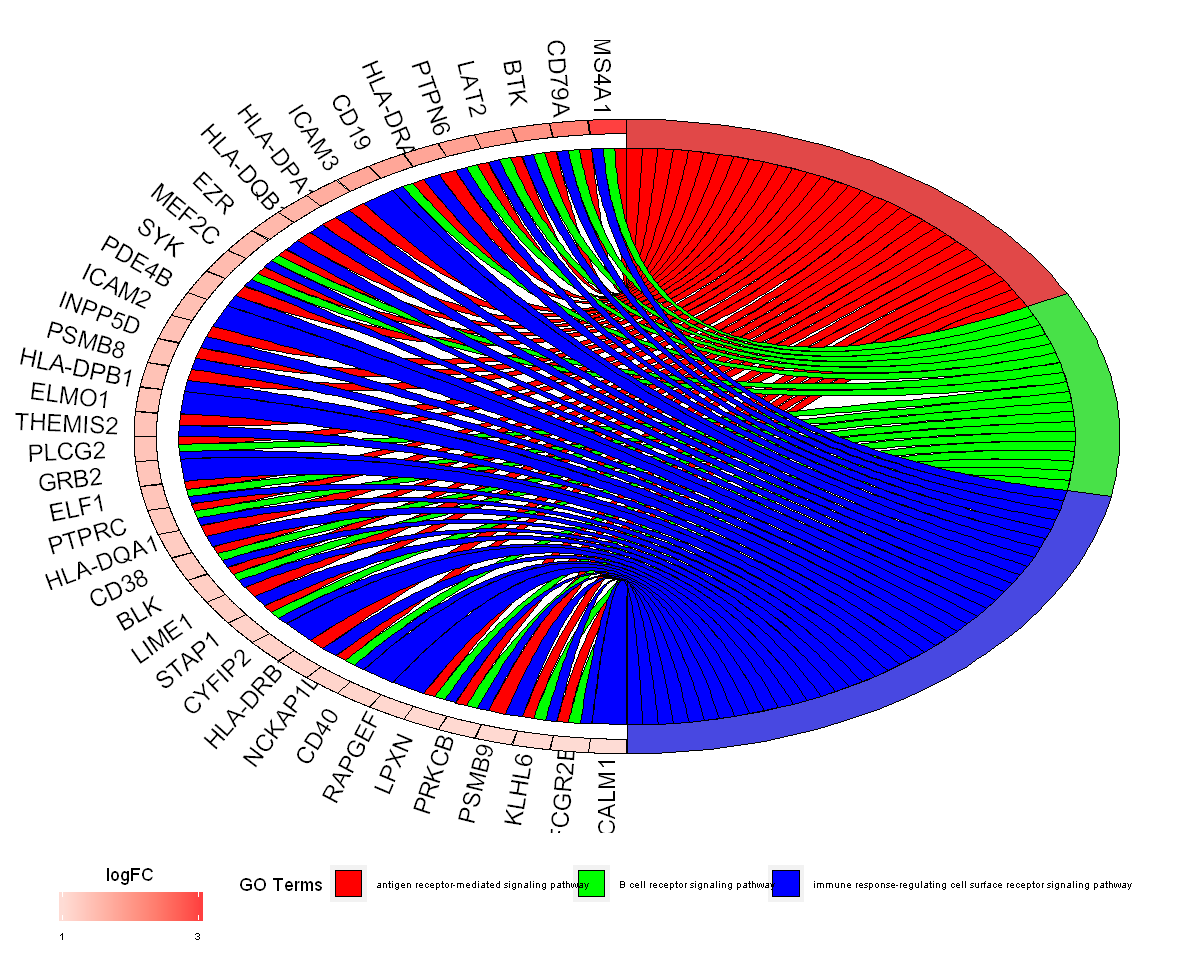

In [366]:
#绘图测试
GOChord(chord, 
        space = 0.001,           #基因之间的间距
        gene.order = 'logFC',    #按照logFC值对基因排序
        gene.space = 0.25,       #基因名跟圆圈的相对距离
        gene.size = 5,           #基因名字体大小 
        border.size = 0.1,       #线条粗细
        process.label = 6)       #term字体大小

In [367]:
pdf(file="9.circ.pdf",width = 11,height = 10.5)
GOChord(chord, 
        space = 0.001,           #基因之间的间距
        gene.order = 'logFC',    #按照logFC值对基因排序
        gene.space = 0.25,       #基因名跟圆圈的相对距离
        gene.size = 5,           #基因名字体大小 
        border.size = 0.1,       #线条粗细
        process.label = 6)       #term字体大小
dev.off()

Warning message:
"Using size for a discrete variable is not advised."
Warning message:
"Removed 3 rows containing missing values (geom_point)."


png 
  2

## 绘制聚类的圈图

In [368]:
termCol <- c("#223D6C","#D20A13","#FFD121","#088247","#58CDD9","#7A142C","#5D90BA","#431A3D","#91612D","#6E568C","#E0367A","#D8D155","#64495D","#7CC767")

Warning message:
"Using size for a discrete variable is not advised."
Warning message:
"Removed 3 rows containing missing values (geom_point)."


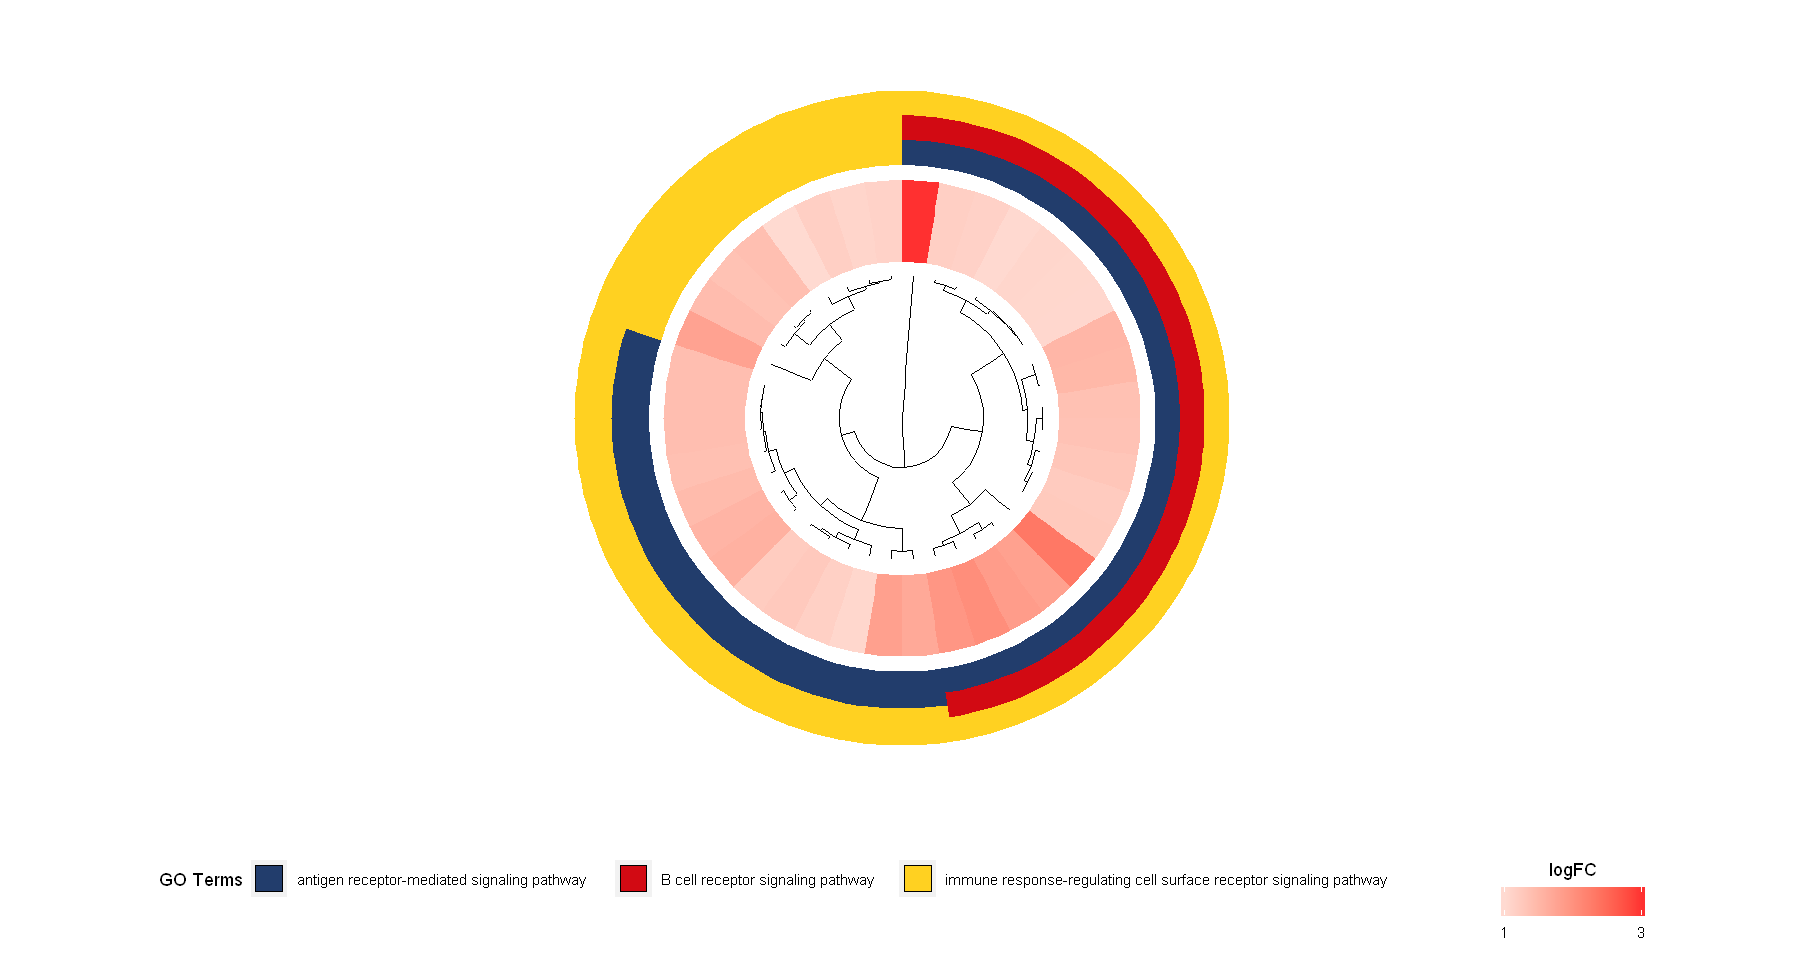

In [372]:
#绘图测试
options(repr.plot.width=15, repr.plot.height=8)  #设置Jupyter Notebook中R绘制的图像大小
GOCluster(circ.gsym, 
          go$Term[1:termNum], 
          lfc.space = 0.2,                   #倍数跟树间的空隙大小
          lfc.width = 1,                     #变化倍数的圆圈宽度
          term.col = termCol[1:termNum],     #自定义term的颜色
          term.space = 0.2,                  #倍数跟term间的空隙大小
          term.width = 1)                    #富集term的圆圈宽度

In [370]:
pdf(file="9.cluster.pdf",width = 15,height = 10)
GOCluster(circ.gsym, 
          go$Term[1:termNum], 
          lfc.space = 0.2,                   #倍数跟树间的空隙大小
          lfc.width = 1,                     #变化倍数的圆圈宽度
          term.col = termCol[1:termNum],     #自定义term的颜色
          term.space = 0.2,                  #倍数跟term间的空隙大小
          term.width = 1)                    #富集term的圆圈宽度
dev.off()          

Warning message:
"Using size for a discrete variable is not advised."
Warning message:
"Removed 3 rows containing missing values (geom_point)."


png 
  2

# KEGG富集分析

In [373]:
library("clusterProfiler")
library("org.Hs.eg.db")
library("enrichplot")
library("ggplot2")

In [374]:
setwd("D:\\Data\\File\\单细胞测序\\scRNA-seq-Bioinformation_analyse\\10.KEGG")             #设置工作目录
rt=read.table("id.txt",sep="\t",header=T,check.names=F)       #读取id.txt文件
rt=rt[is.na(rt[,"entrezID"])==F,]                             #去除基因id为NA的基因
gene=rt$entrezID

## kegg富集分析

In [376]:
kk <- enrichKEGG(gene = gene, organism = "hsa", pvalueCutoff =0.05, qvalueCutoff =0.05)   #富集分析
write.table(kk,file="KEGGId.txt",sep="\t",quote=F,row.names = F)                          #保存富集结果

这一步比较耗时，因为去人的数据库把基因对应的通路都找出来，就会对每种细胞的每个通路都统计有多少基因被富集上。  
然后进行Fish检验，得到p-value
- 如果p-value<0.05，则该Marker基因在该通路上的富集是显著的，反之亦然。

## 柱状图

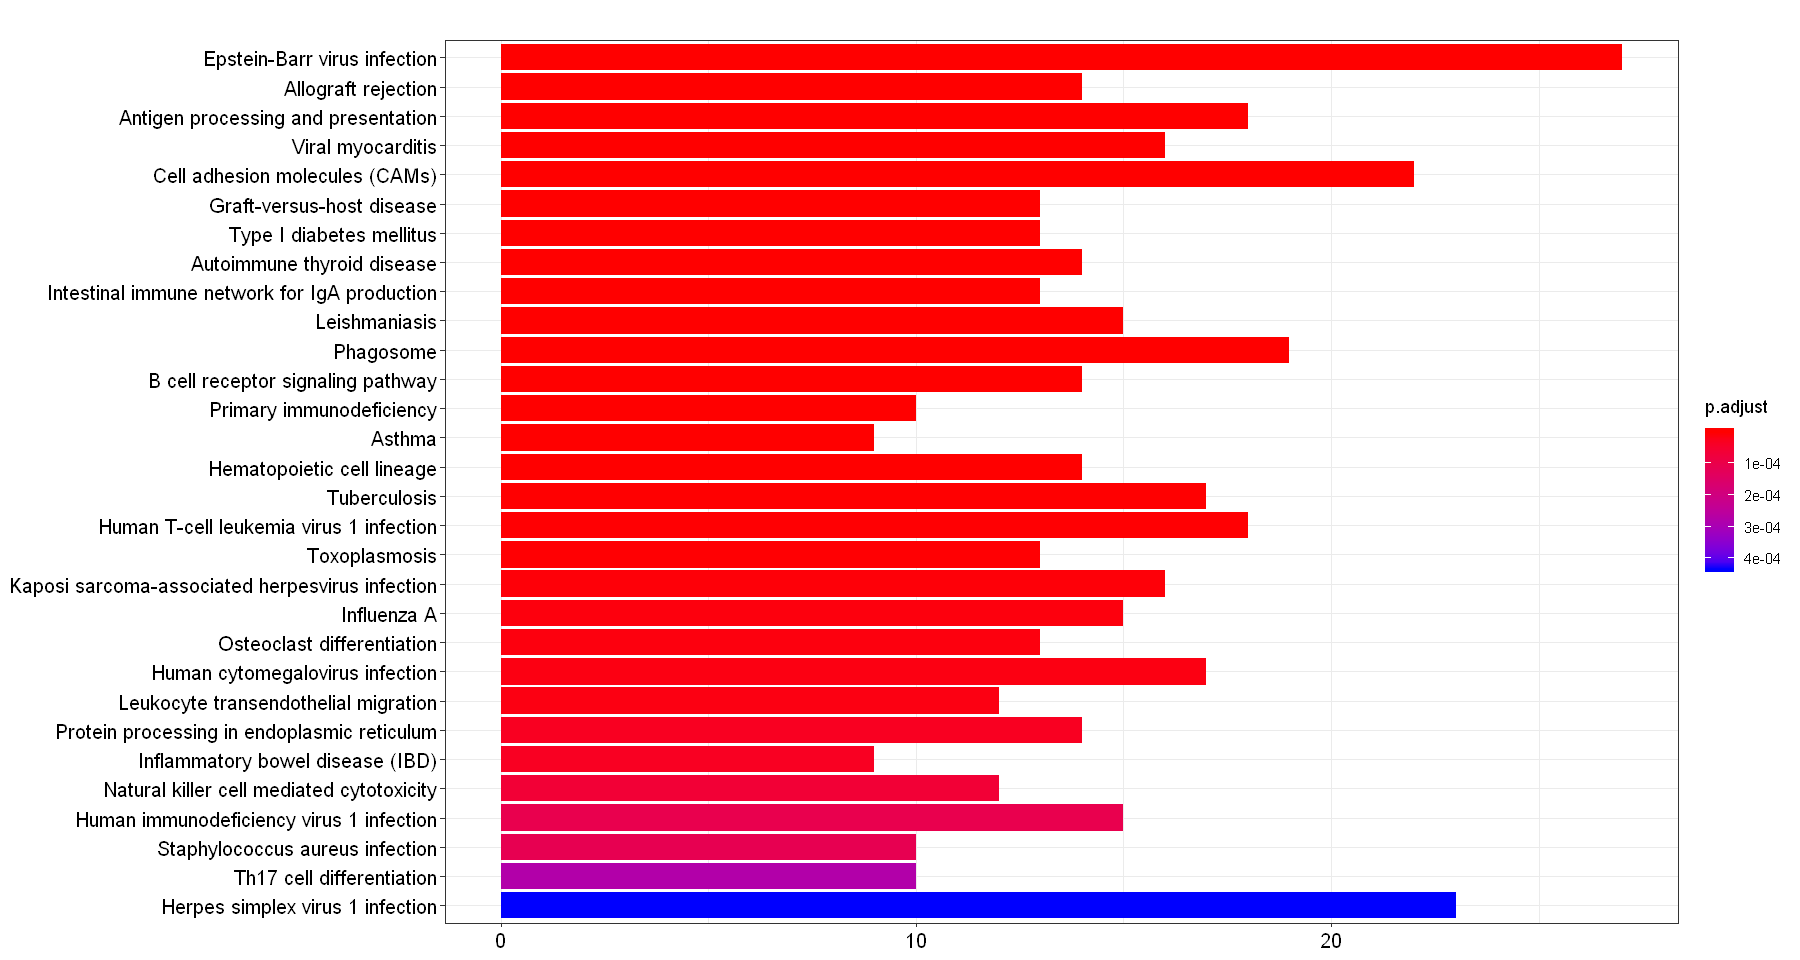

In [377]:
#绘图测试
barplot(kk, drop = TRUE, showCategory = 30)

In [381]:
pdf(file="10.barplot.pdf",width = 10,height = 7)
barplot(kk, drop = TRUE, showCategory = 30)
dev.off()

png 
  2

## 气泡图

wrong orderBy parameter; set to default `orderBy = "x"`



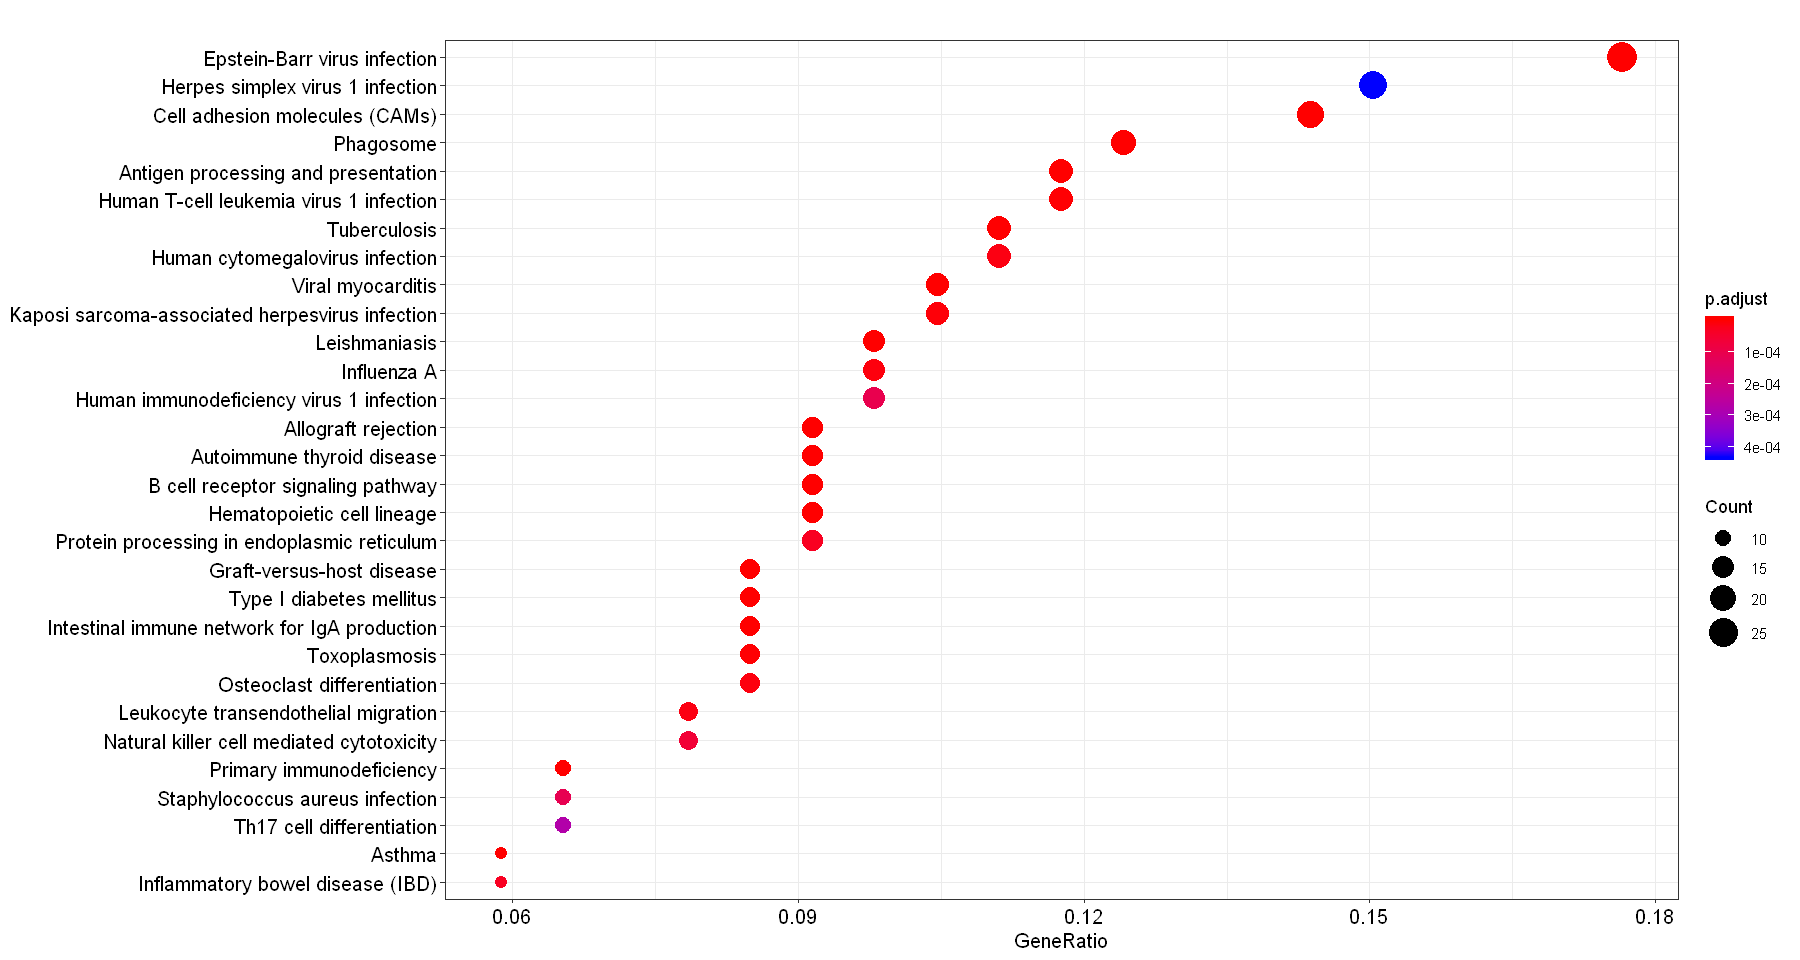

In [380]:
#绘图测试
dotplot(kk, showCategory = 30)

In [382]:
pdf(file="10.bubble.pdf",width = 10,height = 7)
dotplot(kk, showCategory = 30)
dev.off()

wrong orderBy parameter; set to default `orderBy = "x"`



png 
  2

## 转换gene Id到基因名

在文件夹打开Linux子系统或者gitbash终端，输入：

```
perl scRNA.id2symbol.pl
```
运行得到：`kegg.txt`文件
- 文件包含通路与基因的对应关系
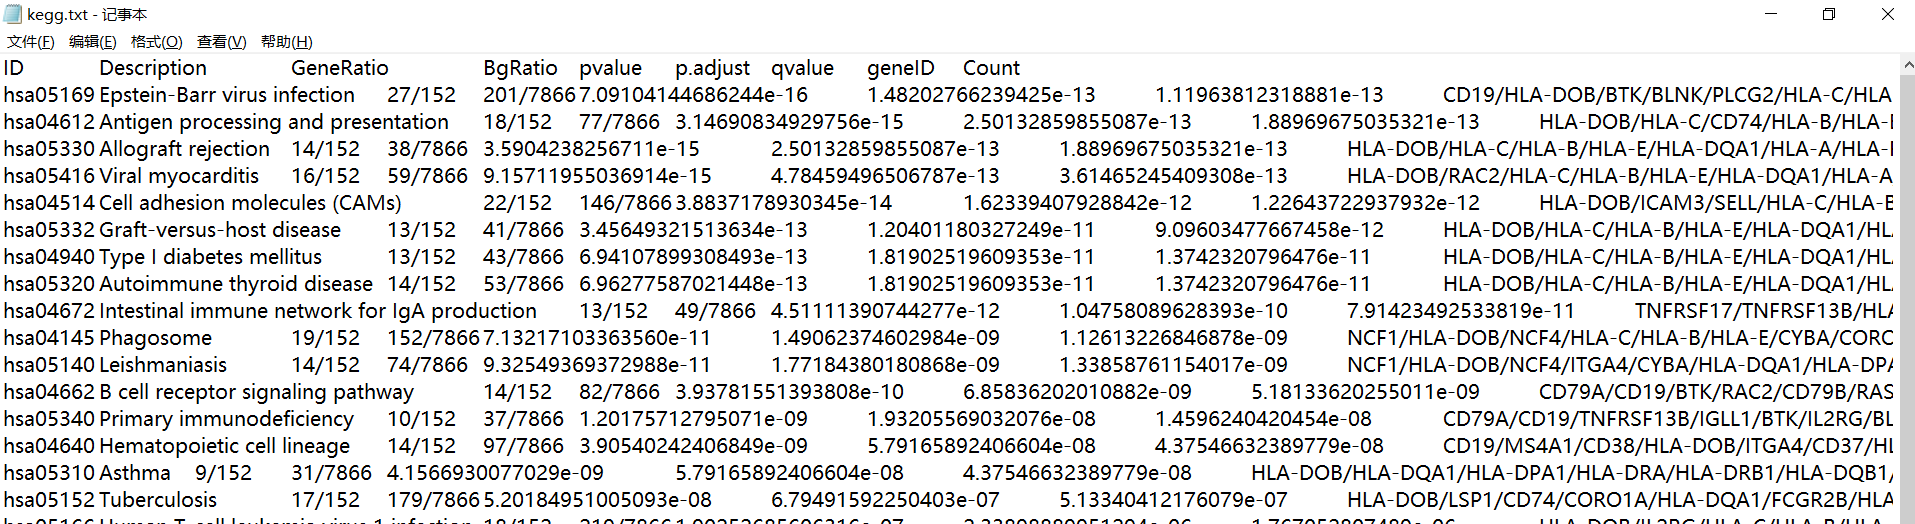

## KEGG圈图

In [388]:
library(GOplot)
setwd("D:\\Data\\File\\单细胞测序\\scRNA-seq-Bioinformation_analyse\\10.KEGG")              #设置工作目录

### 读取kegg富集结果文件

In [389]:
ego=read.table("kegg.txt", header = T,sep="\t",check.names=F)      
go=data.frame(Category = "All",ID = ego$ID,Term = ego$Description, Genes = gsub("/", ", ", ego$geneID), adj_pval = ego$p.adjust)

### 读取基因的logFC文件

In [390]:
id.fc <- read.table("id.txt", header = T,sep="\t",check.names=F)
genelist <- data.frame(ID = id.fc$gene, logFC = id.fc$avg_logFC)
row.names(genelist)=genelist[,1]

### 构造输入参数

In [391]:
circ <- circle_dat(go, genelist)
termNum = 3                                     #限定term数目（一般为3、5、8、10）
geneNum = nrow(genelist)                        #限定基因数目

### 绘制圈图

In [392]:
chord <- chord_dat(circ, genelist[1:geneNum,], go$Term[1:termNum])

Warning message:
"Using size for a discrete variable is not advised."
Warning message:
"Removed 3 rows containing missing values (geom_point)."


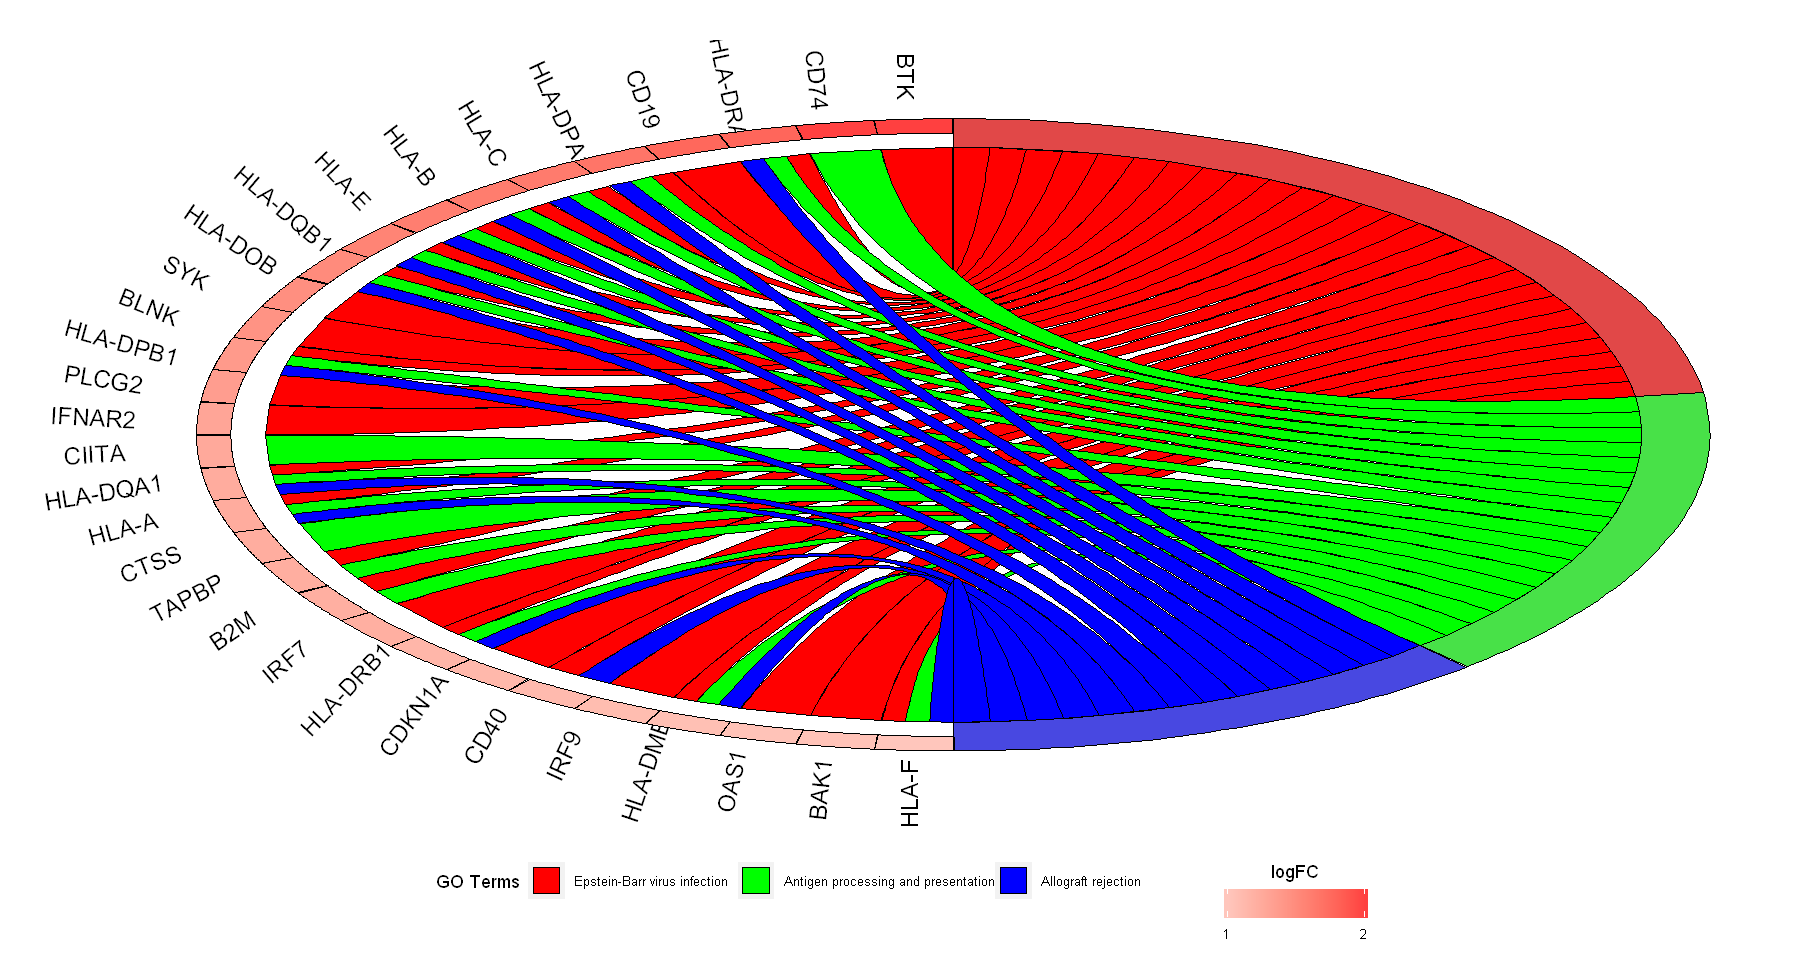

In [394]:
#绘图测试
GOChord(chord, 
        space = 0.001,           #基因之间的间距
        gene.order = 'logFC',    #按照logFC值对基因排序
        gene.space = 0.25,       #基因名跟圆圈的相对距离
        gene.size = 5,           #基因名字体大小 
        border.size = 0.1,       #线条粗细
        process.label = 8)       #term字体大小

In [395]:
pdf(file="10.circ.pdf",width = 11,height = 10)
GOChord(chord, 
        space = 0.001,           #基因之间的间距
        gene.order = 'logFC',    #按照logFC值对基因排序
        gene.space = 0.25,       #基因名跟圆圈的相对距离
        gene.size = 5,           #基因名字体大小 
        border.size = 0.1,       #线条粗细
        process.label = 8)       #term字体大小
dev.off()

Warning message:
"Using size for a discrete variable is not advised."
Warning message:
"Removed 3 rows containing missing values (geom_point)."


png 
  2

### 绘制聚类圈图

In [396]:
termCol <- c("#223D6C","#D20A13","#FFD121","#088247","#58CDD9","#7A142C","#5D90BA","#431A3D","#91612D","#6E568C","#E0367A","#D8D155","#64495D","#7CC767")

Warning message:
"Using size for a discrete variable is not advised."
Warning message:
"Removed 3 rows containing missing values (geom_point)."


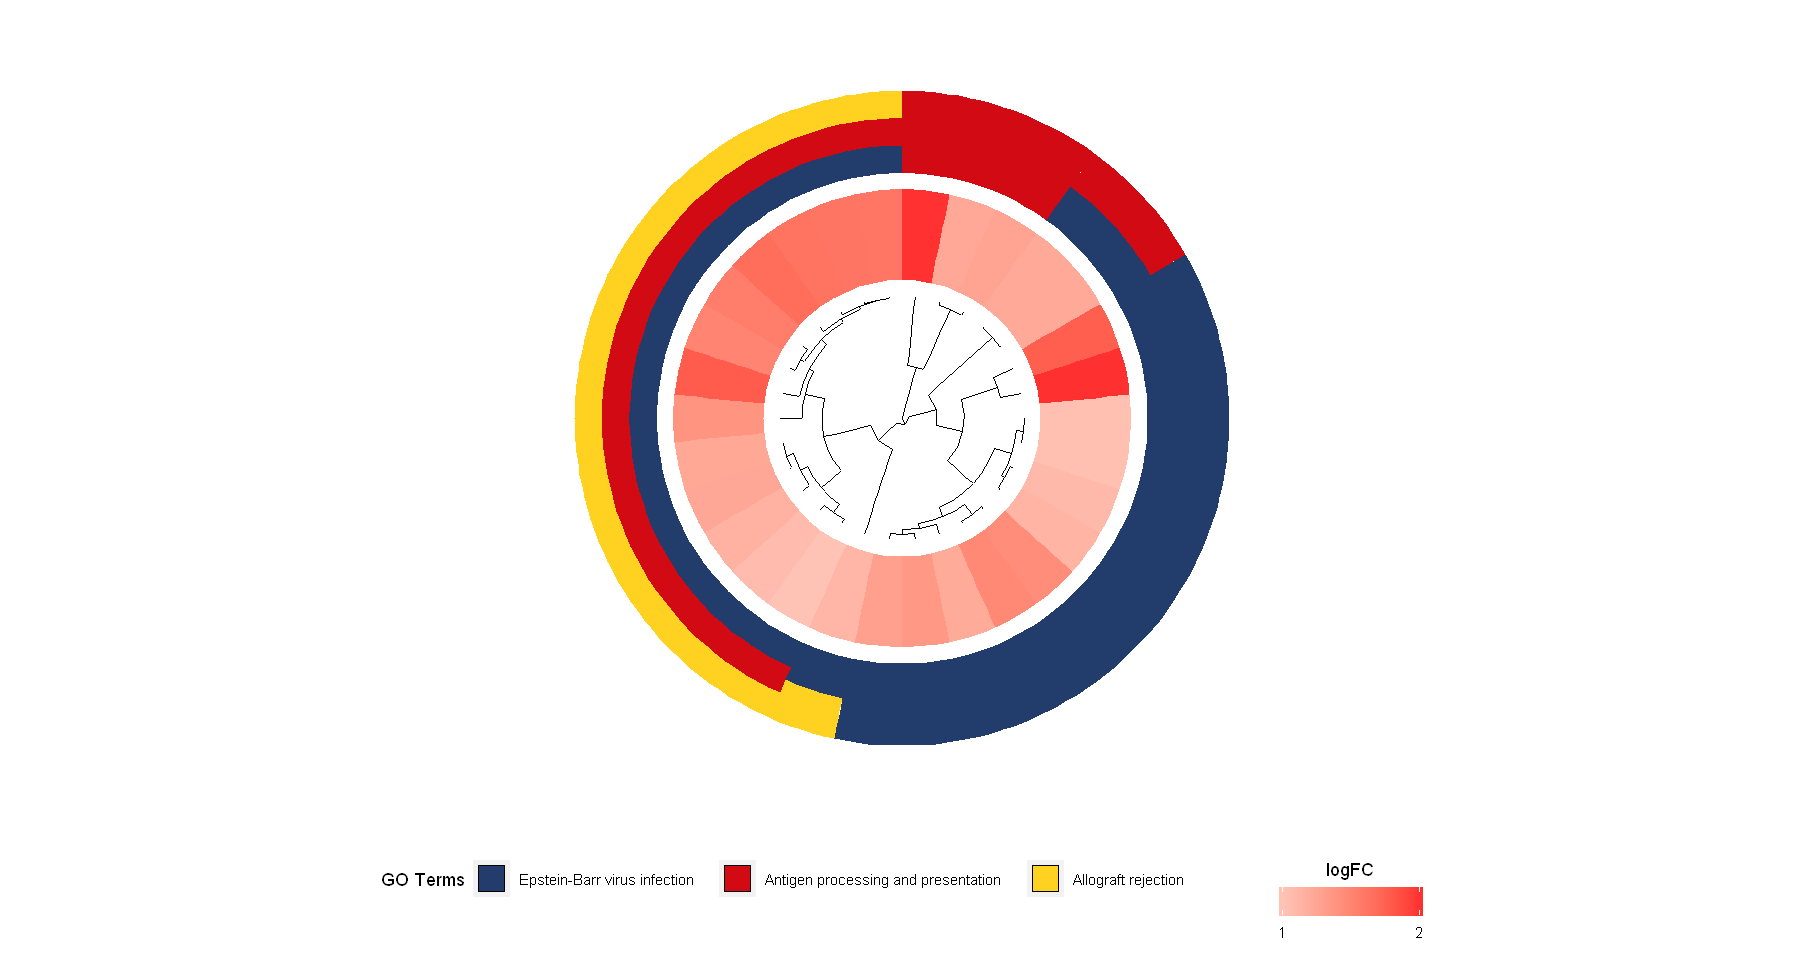

In [398]:
#绘图测试
GOCluster(circ.gsym, 
          go$Term[1:termNum], 
          lfc.space = 0.2,                   #倍数跟树间的空隙大小
          lfc.width = 1,                     #变化倍数的圆圈宽度
          term.col = termCol[1:termNum],     #自定义term的颜色
          term.space = 0.2,                  #倍数跟term间的空隙大小
          term.width = 1)                    #富集term的圆圈宽度

In [400]:
pdf(file="10.cluster.pdf",width = 11,height = 10)
GOCluster(circ.gsym, 
          go$Term[1:termNum], 
          lfc.space = 0.2,                   #倍数跟树间的空隙大小
          lfc.width = 1,                     #变化倍数的圆圈宽度
          term.col = termCol[1:termNum],     #自定义term的颜色
          term.space = 0.2,                  #倍数跟term间的空隙大小
          term.width = 1)                    #富集term的圆圈宽度
dev.off()          

Warning message:
"Using size for a discrete variable is not advised."
Warning message:
"Removed 3 rows containing missing values (geom_point)."


png 
  2